In [1]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from horizonplot import horizonplot
from chromwindow import window
import zarr
import allel

Haploid chrX and diploid with males as homozygous.
I will use the haploid chrX, even though the genotypes end up represented as 0/.
It should not be a problem, as it is just "missing" data.

In [2]:
input_vcf = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chrX_with_males/chrX_haploid_rehead_mnm_sorted.vcf.gz"
zarr_all_chrX = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/all_chrX"
#allel.vcf_to_zarr(input_vcf, zarr_all_chrX, fields='*')
input_vcf = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chrX_with_males/chrX_diploid_all_nomiss.vcf.gz"
zarr_dipmale_chrX = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/dipmale_chrX"
#allel.vcf_to_zarr(input_vcf, zarr_dipmale_chrX, fields='*')
input_vcf = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chrX/chrX.phased.females.vcf.gz"
zarr_chrX = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chrX"
#allel.vcf_to_zarr(input_vcf, zarr_chrX, fields='*')

In [3]:
zarr_chrX_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset_f = zarr.open_group(zarr_chrX_dir, mode="r")
gt_f = allel.GenotypeArray(callset_f["calldata/GT"])
pos_f = callset_f["variants/POS"][:]

zarr_all_chrX_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/all_chrX"
#Opening the zarr data
callset_all_chrX = zarr.open_group(zarr_all_chrX_dir, mode="r")
gt_all_chrX = allel.GenotypeArray(callset_all_chrX["calldata/GT"])
pos_all_chrX = callset_all_chrX["variants/POS"][:]

zarr_dipmale_chrX = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/dipmale_chrX"
#Opening the zarr data
callset_dipmale_chrX = zarr.open_group(zarr_dipmale_chrX, mode="r")

Metadata load

In [4]:
hap_starter = pd.read_csv("../data/haploid_metadata.txt", sep =" ")
meta_data_samples_sci = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

#Generate a mapping between metadata and callset - repeat for chrX females to be sure of no errors.
ID_to_callset = dict(zip(callset_all_chrX["samples"][:], range(len(callset_all_chrX["samples"][:]))))
hap_meta_data_samples = hap_starter.loc[hap_starter.PGDP_ID.isin(callset_all_chrX["samples"][:])].copy()
hap_meta_data_samples["callset_index"] = hap_meta_data_samples.PGDP_ID.map(ID_to_callset)

ID_to_callset_f = dict(zip(callset_f["samples"][:], range(len(callset_f["samples"][:]))))
meta_data_samples_f = meta_data_samples_sci.loc[meta_data_samples_sci.PGDP_ID.isin(callset_f["samples"][:])].copy()
meta_data_samples_f["callset_index"] = meta_data_samples_f.PGDP_ID.map(ID_to_callset_f)

ID_to_callset_dip = dict(zip(callset_dipmale_chrX["samples"][:], range(len(callset_dipmale_chrX["samples"][:]))))
meta_data_samples_dip = meta_data_samples_sci.loc[meta_data_samples_sci.PGDP_ID.isin(callset_dipmale_chrX["samples"][:])].copy()
meta_data_samples_dip["callset_index"] = meta_data_samples_dip.PGDP_ID.map(ID_to_callset_dip)

Baseline df - rfmix data.

In [5]:
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/"
df_l = []
chroms = ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "female_chrX"]
for c in chroms:
    read_file = rfmix_path + "{}.windows.txt".format(c)
    df = pd.read_csv(read_file, sep="\t")
    df_l.append(df)
window_df_eth = pd.concat(df_l)
mean_window_df_eth = window_df_eth.groupby(["chrom", "individual", "start", "end"]).mean().reset_index()

Generalized workflow.
I will use the divergence measure in all cases.
First a for loop for per-ind stats, then a calculation of group-wide stats.

In [10]:
focus_pop_tag = "Anubis, Ethiopia"
donor_1 = "Anubis, Tanzania"
donor_2 = "Hamadryas, Ethiopia"
window_size = 100000
all_chroms = ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "female_chrX", "dipmale_chrX"]

def fst(ac1, ac2):
    num, den = allel.hudson_fst(ac1, ac2, fill=0)
    return np.sum(num) / np.sum(den)

c_df_l = []
for c in []:#["chrX", "dipmale_chrX"]:
    print(c)
    zarr_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/" + c
    #Opening the zarr data
    callset = zarr.open_group(zarr_dir, mode="r")
    gt = allel.GenotypeArray(callset["calldata/GT"])
    pos = callset["variants/POS"][:]
    # Loading in the IDs and gt
    if c == "all_chrX":
        metadata = hap_meta_data_samples
    elif c == "chrX":
        metadata = meta_data_samples_f
    elif c == "dipmale_chrX":
        metadata = meta_data_samples_dip
    else:
        metadata = meta_data_samples
    focus_pop_IDs = metadata.loc[metadata.C_origin == focus_pop_tag].PGDP_ID
    focus_pop_gt = gt.take(metadata.loc[metadata.C_origin == focus_pop_tag].callset_index,
                       axis=1)
    donor_1_pop = metadata.loc[metadata.C_origin == donor_1].callset_index
    donor_1_gt = gt.take(donor_1_pop, axis=1)
    donor_2_pop = metadata.loc[metadata.C_origin == donor_2].callset_index
    donor_2_gt = gt.take(donor_2_pop, axis=1)
    df_l = []
    for ind in focus_pop_IDs:
        if ind[-1:] == "b":
            continue
        elif ind[-1:] == "a":
            focus_ind_gt = focus_pop_gt = gt.take(metadata.loc[metadata.PGDP_ID.isin([ind, ind[:-1]+"b"])].callset_index,
                           axis=1)
            rest_pop_gt = focus_pop_gt = gt.take(metadata.loc[(~metadata.PGDP_ID.isin([ind, ind[:-1]+"b"])) &
                                                                                   metadata.PGDP_ID.isin(focus_pop_IDs)].callset_index,
                           axis=1)
            ID = ind[:-2]
        else:
            focus_ind_gt = focus_pop_gt = gt.take(metadata.loc[metadata.PGDP_ID.isin([ind])].callset_index,
                           axis=1)
            rest_pop_gt = focus_pop_gt = gt.take(metadata.loc[(~metadata.PGDP_ID.isin([ind])) &
                                                                               metadata.PGDP_ID.isin(focus_pop_IDs)].callset_index,
                           axis=1)
            ID = ind
        dxy_focus, windows, n_bases, counts =  allel.windowed_divergence(pos, focus_ind_gt.count_alleles(),
                          rest_pop_gt.count_alleles(), size=window_size, start=0)
        dxy_donor_1, windows, n_bases, counts =  allel.windowed_divergence(pos, focus_ind_gt.count_alleles(),
                          donor_1_gt.count_alleles(), size=window_size, start=0)
        dxy_donor_2, windows, n_bases, counts =  allel.windowed_divergence(pos, focus_ind_gt.count_alleles(),
                          donor_2_gt.count_alleles(), size=window_size, start=0)
        df_l.append(pd.DataFrame({"chrom": c, "individual": ID, "start": windows[:,0], "focus_div": dxy_focus,
                  "donor_1_div": dxy_donor_1, "donor_2_div": dxy_donor_2}))
    focus_df = pd.concat(df_l)
    if c == "chrX":
        rf_c = "female_chrX"
    elif c == "dipmale_chrX":
        rf_c = "all_chrX"
    else:
        rf_c = c
    print(c, rf_c)
    c_rfmix = mean_window_df_eth.loc[mean_window_df_eth.chrom == rf_c]
    c_rfmix["chrom"] = c
    per_ind_df = c_rfmix.merge(focus_df, on=["chrom", "individual", "start"])
    pi, windows, n_bases, counts_pi = allel.windowed_diversity(pos,
                                                        ac=focus_pop_gt.count_alleles(), size=window_size, start=0)
    fst1, windows, counts = allel.windowed_statistic(pos, (focus_pop_gt.count_alleles(),
                                                      donor_1_gt.count_alleles()), fst, size=window_size, start=0)
    fst2, windows, counts = allel.windowed_statistic(pos, (focus_pop_gt.count_alleles(),
                                                      donor_2_gt.count_alleles()), fst, size=window_size, start=0)
    theta_hat_w, windows, n_bases, counts = allel.windowed_watterson_theta(pos,
                                                        ac=focus_pop_gt.count_alleles(), size=window_size, start=0)

    group_stats = pd.DataFrame({"chrom": c, "start": windows[:,0], "pi": pi, "count": counts_pi,
                            "fst_1": fst1, "fst_2": fst2, "w_theta": theta_hat_w})
    ind_group_df = per_ind_df.merge(group_stats, on=["chrom", "start"])
    ind_group_df.to_csv("../steps/rfmix_stats_df/{}_stats.txt".format(c), index=False)

In [14]:
window_size = 100000
all_chroms = ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "chrX", "dipmale_chrX"]

df_l = []
for c in all_chroms:
    read_file = "../steps/rfmix_stats_df/{}_stats.txt".format(c)
    df = pd.read_csv(read_file)
    df_l.append(df)
window_df_eth = pd.concat(df_l)

In [15]:
window_df_eth.chrom.unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'all_chrX', 'chrX',
       'dipmale_chrX'], dtype=object)

In [16]:
chrom_map = {}
for c in all_chroms:
    if c in ["chr{}".format(x) for x in (range(1, 21))]:
        chrom_map[c] = "autosome"
    else:
        chrom_map[c] = c
window_df_eth["chrtype"] = window_df_eth.chrom.map(chrom_map)

In [17]:
hamadryas_ancestry = window_df_eth.groupby(["chrom", "start"])[["north_sum",
                                                "pi", "fst_1", "fst_2", 
                                               "donor_1_div", "donor_2_div"]].mean().reset_index()
hamadryas_ancestry["Hamadryas Ancestry"] = hamadryas_ancestry.north_sum/(hamadryas_ancestry.north_sum.max())

In [18]:
hamadryas_ancestry["ancestry"] = ["olive" if x <= 0.20 else "hamadryas" if x >= 0.8
                        else "mixed" for x in hamadryas_ancestry["Hamadryas Ancestry"]]
hamadryas_ancestry["chrtype"] = hamadryas_ancestry.chrom.map(chrom_map)

<Axes: xlabel='ancestry', ylabel='pi'>

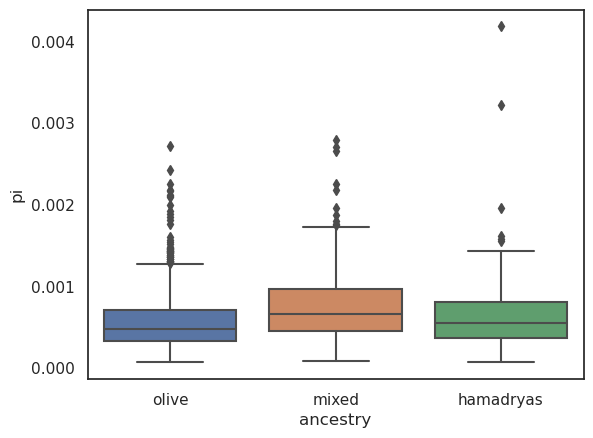

In [19]:
sns.boxplot(data=hamadryas_ancestry.loc[hamadryas_ancestry.chrtype == "chrX"], y="pi", x="ancestry")

In [20]:
hamadryas_ancestry.loc[hamadryas_ancestry.chrtype == "chrX"].pi.mean()/hamadryas_ancestry.loc[hamadryas_ancestry.chrtype == "autosome"].pi.mean()

0.3620860599388783

<Axes: xlabel='ancestry', ylabel='pi'>

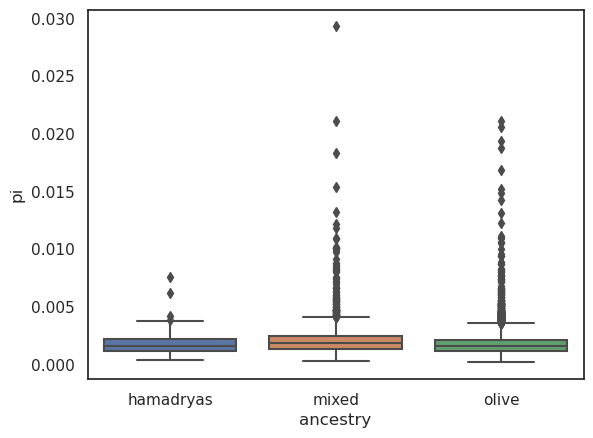

In [21]:
sns.boxplot(data=hamadryas_ancestry.loc[hamadryas_ancestry.chrtype == "autosome"], y="pi", x="ancestry")

<Axes: xlabel='ancestry', ylabel='pi'>

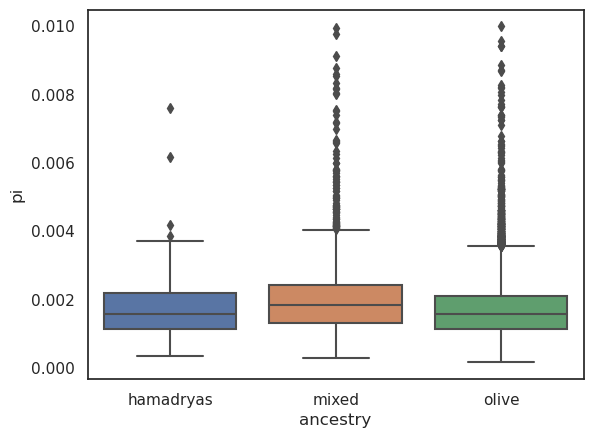

In [22]:
sns.boxplot(data=hamadryas_ancestry.loc[(hamadryas_ancestry.chrtype == "autosome") &
                                       (hamadryas_ancestry.pi < 0.01)], y="pi", x="ancestry")

<Axes: xlabel='ancestry', ylabel='pi'>

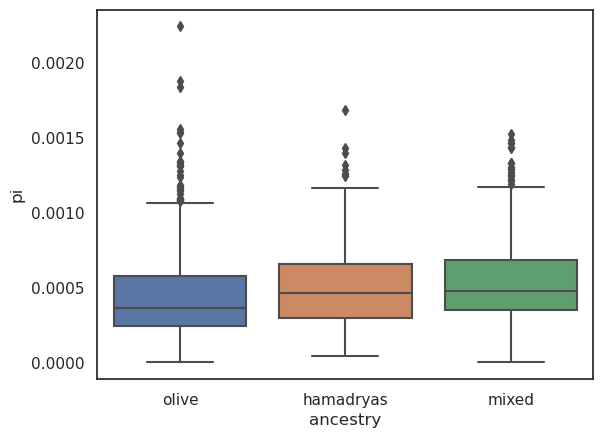

In [23]:
sns.boxplot(data=hamadryas_ancestry.loc[hamadryas_ancestry.chrtype == "all_chrX"], y="pi", x="ancestry")

In [24]:
h_auto = hamadryas_ancestry.loc[(hamadryas_ancestry.chrtype == "autosome") &
                      (hamadryas_ancestry.ancestry == "hamadryas")]
h_x = hamadryas_ancestry.loc[(hamadryas_ancestry.chrtype == "chrX") &
                      (hamadryas_ancestry.ancestry == "hamadryas")]
o_auto = hamadryas_ancestry.loc[(hamadryas_ancestry.chrtype == "autosome") &
                      (hamadryas_ancestry.ancestry == "olive")]
o_x = hamadryas_ancestry.loc[(hamadryas_ancestry.chrtype == "chrX") &
                      (hamadryas_ancestry.ancestry == "olive")]
m_auto = hamadryas_ancestry.loc[(hamadryas_ancestry.chrtype == "autosome") &
                      (hamadryas_ancestry.ancestry == "mixed")]
m_x = hamadryas_ancestry.loc[(hamadryas_ancestry.chrtype == "chrX") &
                      (hamadryas_ancestry.ancestry == "mixed")]

In [28]:
h_x.pi.mean()/h_auto.pi.mean(), h_auto.pi.mean()

(0.36054882750925954, 0.0017542893457369484)

In [29]:
o_x.pi.mean()/o_auto.pi.mean(), o_auto.pi.mean()

(0.33449934002712034, 0.001689740137098866)

In [31]:
m_x.pi.mean()/m_auto.pi.mean(), m_auto.pi.mean()

(0.3760934878405405, 0.002000068564877457)

Adding other statistics. Section one is callability, recombination and gene content.

In [58]:
mask_dir = "/home/eriks/primatediversity/people/erik/Primate_Het_X_Autosome/data/callmasks/"

chroms = ["chr{}".format(x) for x in (range(1, 21))] + ["chrX"] #+["all_chrX", "female_chrX", "dipmale_chrX"]

mask_df_l = []
for c in chroms:
    print(c)
    mask_df = pd.read_csv(mask_dir+"cutoff_10_all_baboons_{}_min_third_merged.bed".format("chrX"), sep='\t',
                         comment='t', header=None, names=["chrom", "chromStart", "chromEnd"])
    mask_percentage = []
    for i in range(0, mask_df.chromEnd.iloc[-1], window_size):
        mask_subset = mask_df.loc[(mask_df.chromEnd >= i) & (mask_df.chromStart < i+window_size)]
        start_sum, end_sum = sum(mask_subset.chromStart), sum(mask_subset.chromEnd)
        if mask_subset.chromStart.iloc[0] < i:
            start_sum=start_sum-mask_subset.chromStart.iloc[0]+i
        if mask_subset.chromEnd.iloc[-1] > i+window_size:
            end_sum=end_sum-mask_subset.chromEnd.iloc[-1]+i+window_size
        mask_percentage.append((end_sum-start_sum)/window_size)
    mask_df = pd.DataFrame({"chrom": c, "start": list(range(0, mask_df.chromEnd.iloc[-1], window_size)),
                           "callable_frac": mask_percentage})
    mask_df_l.append(mask_df)
mask_df_all_chroms = pd.concat(mask_df_l)
import geneinfo as gi
%env ftp_proxy http://proxy-default:3128
%env http_proxy http://proxy-default:3128
%env https_proxy http://proxy-default:3128
gene_df_l = []        

for c in chroms: #["all_chrX"]: #window_df.chrom.unique()[:1]:
    pos_mapping = {}
    print(c)
    chr_df = mask_df_all_chroms.loc[(mask_df_all_chroms.chrom == c)]
    windows = chr_df.start.unique()
    max_window = windows.max()
    genetic_map = "/home/eriks/baboondiversity/data/PG_panu3_recombination_map/mikumi_pyrho_genetic_map_{}.txt"
    if c not in ["all_chrX", "female_chrX", "dipmale_chrX"]:
        chr_recomb = pd.read_csv(genetic_map.format(c), sep=" ")
        chr_genes = gi.get_genes_region(c, 0, max_window, assembly='papAnu4')
    else:
        chr_recomb = pd.read_csv(genetic_map.format(c), sep=" ")
        chr_genes = gi.get_genes_region(c, 0, max_window, assembly='papAnu4')
    for s in chr_df.start.unique():
        if s % 25000000 == 0:
            print(s/max_window)
        cM_sub = chr_recomb.loc[chr_recomb.position >= s]
        if len(cM_sub) > 0:
            cM_pos = chr_recomb.loc[chr_recomb.position >= s]["Genetic_Map(cM)"].iloc[0]
            pos_mapping[s] = cM_pos
        else:
            pos_mapping[s] = chr_recomb["Genetic_Map(cM)"].max()
    chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
    chr_df["cM"] = chr_df.start.map(pos_mapping)
    pushed_cM = list(pos_mapping.values())[1:]+[chr_recomb["Genetic_Map(cM)"].max()]
    chr_df["end_cM"] = chr_df.start.map(dict(zip(pos_mapping.keys(), pushed_cM)))
    chr_df["average_cM_window"] = (chr_df.end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
    gene_list = []
    gene_pos_mapping = {}
    for g in chr_genes:
        #print(g)
        if g in gene_list or g[0][:3] == "LOC":
            pass
        else:
            gene_list.append(g)
    for w in range(0, max_window+100000, 100000):
        gene_pos_mapping[w] = []
    for g in gene_list:
        s, e = (g[1]//100000)*100000, (g[2]//100000)*100000
        for i in range(s, e+100000, 100000):
            gene_pos_mapping[i].append(g[0])
    chr_df["genes"] = chr_df.start.map(gene_pos_mapping)
    chr_df["genic"] = [True if len(x) > 0 else False for x in chr_df.genes]
    gene_df_l.append(chr_df)

c_r_g_df = pd.concat(gene_df_l)
c_r_g_df.to_csv("../steps/rfmix_stats_df/call_recomb_genes.txt", index=False)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chrX
env: ftp_proxy=http://proxy-default:3128
env: http_proxy=http://proxy-default:3128
env: https_proxy=http://proxy-default:3128
chr1
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr2
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr3
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr4
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr5
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr6
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr7
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr8
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr9
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr10
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr11
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr12
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr13
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr14
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr15
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr16
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr17
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr18
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr19
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chr20
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

chrX
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/25455825/ipykernel_4064143/881949475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["end"] = list(pos_mapping.keys())[1:]+[chr_recomb.position.max()]
/scratch/25455825/ipykernel_4064143/881949475.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/25455825/ipykernel_4064143/881949475.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [59]:
c_r_g_df

,chrom,start,callable_frac,end,cM,end_cM,average_cM_window,genes,genic
0,chr1,0,0.04690,100000,0.000000,0.360307,3.603071e-06,"[RNF223, C1H1orf159, C1H1orf159, C1H1orf159, C...",True
1,chr1,100000,0.64769,200000,0.360307,0.476530,1.162234e-06,"[TTLL10, TTLL10, TTLL10, TTLL10, TTLL10, TTLL1...",True
2,chr1,200000,0.95965,300000,0.476530,0.547039,7.050811e-07,"[B3GALT6, C1QTNF12, UBE2J2, UBE2J2, UBE2J2, UB...",True
3,chr1,300000,0.94918,400000,0.547039,0.626412,7.937342e-07,"[DVL1, DVL1, DVL1, MXRA8, MXRA8, MXRA8, AURKAI...",True
4,chr1,400000,0.78703,500000,0.626412,1.366901,7.404885e-06,"[VWA1, TMEM240, SSU72]",True
...,...,...,...,...,...,...,...,...,...
1432,chrX,143200000,0.66998,143300000,126.757529,126.783155,2.562611e-07,"[TMLHE, TMLHE, TMLHE, TMLHE, TMLHE]",True
1433,chrX,143300000,0.90454,143400000,126.783155,126.816893,3.373798e-07,"[TMLHE, TMLHE, TMLHE, TMLHE]",True
1434,chrX,143400000,0.78855,143500000,126.816893,126.844878,2.798504e-07,[SPRY3],True
1435,chrX,143500000,0.83590,143600000,126.844878,126.920225,7.534706e-07,[VAMP7],True


In [66]:
chroms = ["{}".format(x) for x in (range(1, 21))] + ["X", "hapX"]

pval_df_l = []
for c in chroms:
    pos_list, pval_list = [], []
    relate_sele = pd.read_csv("../results/Tanzania_Olive_relate/chrom{}_selection.sele".format(c), sep=" ")
    relate_sele["-log10 P-value"] = -relate_sele["when_mutation_has_freq2"]
    for i in range(0, relate_sele.pos.iloc[-1], window_size):
        sub_df = relate_sele.loc[(relate_sele.pos >= i) & (relate_sele.pos < i+window_size)]
        if len(sub_df) > 1:
            sorted_df = sub_df.sort_values(["-log10 P-value"], ascending = False)
            pos_list.append(sorted_df.pos.iloc[0]), pval_list.append(sorted_df["-log10 P-value"].iloc[0])
        else:
            pos_list.append(np.NaN), pval_list.append(0)
    pval_df = pd.DataFrame({"chrom": "chr"+c, "start": list(range(0, relate_sele.pos.iloc[-1], window_size)),
                              "peak_pos": pos_list, "pval": pval_list})
    pval_df_l.append(pval_df)
        
sel_df = pd.concat(pval_df_l)
sel_df.to_csv("../steps/rfmix_stats_df/tanzania_olive_pval_peaks.txt", index=False)

In [71]:
sel_df.loc[sel_df.pval > 8]

,chrom,start,peak_pos,pval
638,chr1,63800000,63881300.0,8.12164
1832,chr1,183200000,183223544.0,8.12164
28,chr2,2800000,2813344.0,8.14883
1014,chr2,101400000,101487379.0,8.24395
1037,chr2,103700000,103761155.0,8.25350
1103,chr2,110300000,110337810.0,8.65575
1210,chr2,121000000,121007104.0,9.22094
1544,chr2,154400000,154421537.0,8.07492
1703,chr2,170300000,170314461.0,8.64145
76,chr3,7600000,7695155.0,8.25350


Below this point: Older code, kept for good measure.

In [7]:
focus_pop_tag = "Anubis, Ethiopia"
c = "all_chrX"
window_size = 100000

focus_pop_IDs = hap_meta_data_samples.loc[hap_meta_data_samples.C_origin == focus_pop_tag].PGDP_ID
focus_pop_gt = gt_all_chrX.take(hap_meta_data_samples.loc[hap_meta_data_samples.C_origin == focus_pop_tag].callset_index,
                       axis=1)
donor_1_pop = hap_meta_data_samples.loc[hap_meta_data_samples.C_origin == "Anubis, Tanzania"].callset_index
donor_1_gt = gt_all_chrX.take(donor_1_pop, axis=1)
donor_2_pop = hap_meta_data_samples.loc[hap_meta_data_samples.C_origin == "Hamadryas, Ethiopia"].callset_index
donor_2_gt = gt_all_chrX.take(donor_2_pop, axis=1)

df_l = []
for ind in focus_pop_IDs:
    if ind[-1:] == "b":
        continue
    elif ind[-1:] == "a":
        focus_ind_gt = focus_pop_gt = gt_all_chrX.take(hap_meta_data_samples.loc[hap_meta_data_samples.PGDP_ID.isin([ind, ind[:-1]+"b"])].callset_index,
                       axis=1)
        rest_pop_gt = focus_pop_gt = gt_all_chrX.take(hap_meta_data_samples.loc[(~hap_meta_data_samples.PGDP_ID.isin([ind, ind[:-1]+"b"])) &
                                                                               hap_meta_data_samples.PGDP_ID.isin(focus_pop_IDs)].callset_index,
                       axis=1)
        ID = ind[:-2]
    else:
        focus_ind_gt = focus_pop_gt = gt_all_chrX.take(hap_meta_data_samples.loc[hap_meta_data_samples.PGDP_ID.isin([ind])].callset_index,
                       axis=1)
        rest_pop_gt = focus_pop_gt = gt_all_chrX.take(hap_meta_data_samples.loc[(~hap_meta_data_samples.PGDP_ID.isin([ind])) &
                                                                               hap_meta_data_samples.PGDP_ID.isin(focus_pop_IDs)].callset_index,
                       axis=1)
        ID = ind
    dxy_focus, windows, n_bases, counts =  allel.windowed_divergence(pos_all_chrX, focus_ind_gt.count_alleles(),
                          rest_pop_gt.count_alleles(), size=window_size, start=0)
    dxy_donor_1, windows, n_bases, counts =  allel.windowed_divergence(pos_all_chrX, focus_ind_gt.count_alleles(),
                          donor_1_gt.count_alleles(), size=window_size, start=0)
    dxy_donor_2, windows, n_bases, counts =  allel.windowed_divergence(pos_all_chrX, focus_ind_gt.count_alleles(),
                          donor_2_gt.count_alleles(), size=window_size, start=0)
    df_l.append(pd.DataFrame({"chrom": c, "individual": ID, "start": windows[:,0], "focus_div": dxy_focus,
                  "donor_1_div": dxy_donor_1, "donor_2_div": dxy_donor_2}))
focus_df = pd.concat(df_l)

Merge rfmix and per-ind stats

In [8]:
per_ind_df = mean_window_df_eth.merge(focus_df, on=["chrom", "individual", "start"])

Generate grouped stats

In [27]:
def fst(ac1, ac2):
    num, den = allel.hudson_fst(ac1, ac2, fill=0)
    return np.sum(num) / np.sum(den)

def pbs_window(pos, ac1, ac2, ac3, window_size, window_start=0, window_stop=None,
        window_step=None, normed=True):
    from allel.util import asarray_ndim, check_dim0_aligned, check_integer_dtype
    ac1 = allel.AlleleCountsArray(ac1)
    ac2 = allel.AlleleCountsArray(ac2)
    ac3 = allel.AlleleCountsArray(ac3)
    check_dim0_aligned(ac1, ac2, ac3)

    # compute fst
    fst12, windows, counts = allel.windowed_hudson_fst(pos, ac1, ac2, size=window_size, start=window_start,
                              stop=window_stop, step=window_step)
    fst13, windows, counts = allel.windowed_hudson_fst(pos, ac1, ac3, size=window_size, start=window_start,
                              stop=window_stop, step=window_step)
    fst23, windows, counts = allel.windowed_hudson_fst(pos, ac2, ac3, size=window_size, start=window_start,
                              stop=window_stop, step=window_step)

    # clip fst values to avoid infinite if fst is 1
    for x in fst12, fst13, fst23:
        np.clip(x, a_min=0, a_max=0.99999, out=x)

    # compute fst transform
    t12 = -np.log(1 - fst12)
    t13 = -np.log(1 - fst13)
    t23 = -np.log(1 - fst23)

    # compute pbs
    ret = (t12 + t13 - t23) / 2

    if normed:
        # compute pbs normalising constant
        norm = 1 + (t12 + t13 + t23) / 2
        ret = ret / norm

    return ret

pi, windows, n_bases, counts_pi = allel.windowed_diversity(pos_all_chrX,
                                                        ac=focus_pop_gt.count_alleles(), size=window_size, start=0)
fst1, windows, counts = allel.windowed_statistic(pos_all_chrX, (focus_pop_gt.count_alleles(),
                                                      donor_1_gt.count_alleles()), fst, size=window_size, start=0)
fst2, windows, counts = allel.windowed_statistic(pos_all_chrX, (focus_pop_gt.count_alleles(),
                                                      donor_2_gt.count_alleles()), fst, size=window_size, start=0)
theta_hat_w, windows, n_bases, counts = allel.windowed_watterson_theta(pos_all_chrX,
                                                        ac=focus_pop_gt.count_alleles(), size=window_size, start=0)

pbs = pbs_window(pos_all_chrX, focus_pop_gt.count_alleles(), donor_1_gt.count_alleles(),
           donor_2_gt.count_alleles(), window_size)

group_stats = pd.DataFrame({"chrom": c, "start": windows[:,0], "pi": pi, "count": counts_pi,
                            "fst_1": fst1, "fst_2": fst2, "w_theta": theta_hat_w, "pbs": pbs})

In [28]:
ind_group_df = per_ind_df.merge(group_stats, on=["chrom", "start"])

Adding three grouped stats of interest: strongest selective sweep found by Relate, callability, recombination rate and genes in windows.

In [29]:
relate_sele = pd.read_csv("../results/Ethiopian_Olive_relate/chromhapX_selection.sele", sep=" ")
relate_sele["-log10 P-value"] = -relate_sele["when_mutation_has_freq2"]

pos_list, pval_list = [], []

for i in range(0, relate_sele.pos.iloc[-1], window_size):
    sub_df = relate_sele.loc[(relate_sele.pos >= i) & (relate_sele.pos < i+window_size)]
    if len(sub_df) > 1:
        sorted_df = sub_df.sort_values(["-log10 P-value"], ascending = False)
        pos_list.append(sorted_df.pos.iloc[0]), pval_list.append(sorted_df["-log10 P-value"].iloc[0])
    else:
        pos_list.append(np.NaN), pval_list.append(0)

In [31]:
sm_df = pd.DataFrame({"start": list(range(0, mask_df.chromEnd.iloc[-1], window_size)), "sweep_pos": pos_list,
             "pval": pval_list, "callable_fraction": mask_percentage})

In [32]:
smig_df = ind_group_df.merge(sm_df, on=["start"])

In [71]:
import geneinfo as gi
%env ftp_proxy http://proxy-default:3128
%env http_proxy http://proxy-default:3128
%env https_proxy http://proxy-default:3128
pos_mapping = {}
recomb_window_l = []
for c in ["all_chrX"]: #window_df.chrom.unique()[:1]:
    print(c)
    chr_df = smig_df.loc[(smig_df.chrom == c)]
    windows = chr_df.start.unique()
    max_window = windows.max()
    genetic_map = "/home/eriks/baboondiversity/data/PG_panu3_recombination_map/mikumi_pyrho_genetic_map_{}.txt"
    if c not in ["all_chrX", "female_chrX", "dipmale_chrX"]:
        chr_recomb = pd.read_csv(genetic_map.format(c), sep=" ")
        chr_genes = gi.get_genes_region(c, 0, max_window, assembly='papAnu4')
    else:
        chr_recomb = pd.read_csv(genetic_map.format("chrX"), sep=" ")
        chr_genes = gi.get_genes_region('chrX', 0, max_window, assembly='papAnu4')
    for s in chr_df.start.unique():
        if s % 25000000 == 0:
            print(s/max_window)
        cM_pos = chr_recomb.loc[chr_recomb.position >= s]["Genetic_Map(cM)"].iloc[0]
        pos_mapping[s] = cM_pos
    chr_df["cM"] = chr_df.start.map(pos_mapping)
    pushed_cM = list(pos_mapping.values())[1:]+[chr_recomb["Genetic_Map(cM)"].max()]
    chr_df["end_cM"] = chr_df.start.map(dict(zip(pos_mapping.keys(), pushed_cM)))
    chr_df["average_cM_window"] = (chr_df.end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
    gene_list = []
    gene_pos_mapping = {}
    for g in chr_genes:
        #print(g)
        if g in gene_list or g[0][:3] == "LOC":
            pass
        else:
            gene_list.append(g)
    for w in range(0, max_window+100000, 100000):
        gene_pos_mapping[w] = []
    for g in gene_list:
        s, e = (g[1]//100000)*100000, (g[2]//100000)*100000
        for i in range(s, e+100000, 100000):
            gene_pos_mapping[i].append(g[0])
    chr_df["genes"] = chr_df.start.map(gene_pos_mapping)
    chr_df["genic"] = [True if len(x) > 0 else False for x in chr_df.genes]

env: ftp_proxy=http://proxy-default:3128
env: http_proxy=http://proxy-default:3128
env: https_proxy=http://proxy-default:3128
all_chrX
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


Now, everything is in the chr_df dataframe.

In [73]:
chr_df = chr_df.loc[chr_df.start > 2500000]

<Axes: xlabel='average_cM_window', ylabel='Count'>

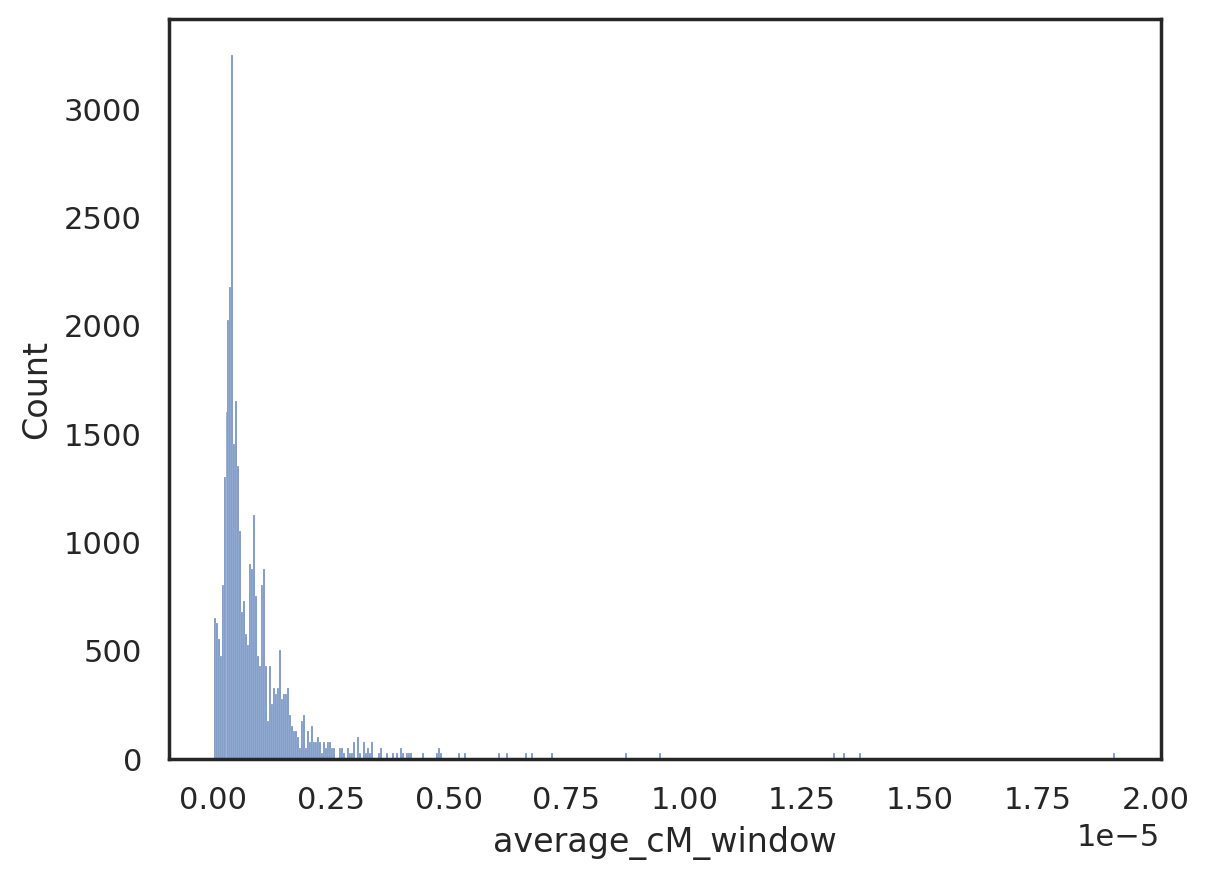

In [75]:
sns.histplot(chr_df["average_cM_window"])

In [95]:
hamadryas_ancestry = chr_df.groupby(["start"])[["north_sum", "callable_fraction",
                                                "pi", "pval", "fst_1", "fst_2", "pbs", "average_cM_window", 
                                               "donor_1_div", "donor_2_div"]].mean().reset_index()
hamadryas_ancestry["Hamadryas Ancestry"] = hamadryas_ancestry.north_sum/(hamadryas_ancestry.north_sum.max())
hamadryas_ancestry["Callable"] = ["Callable" if x > 0.9 else "Uncalled" for x in hamadryas_ancestry.callable_fraction]

Text(0.5, 1.0, 'chrX')

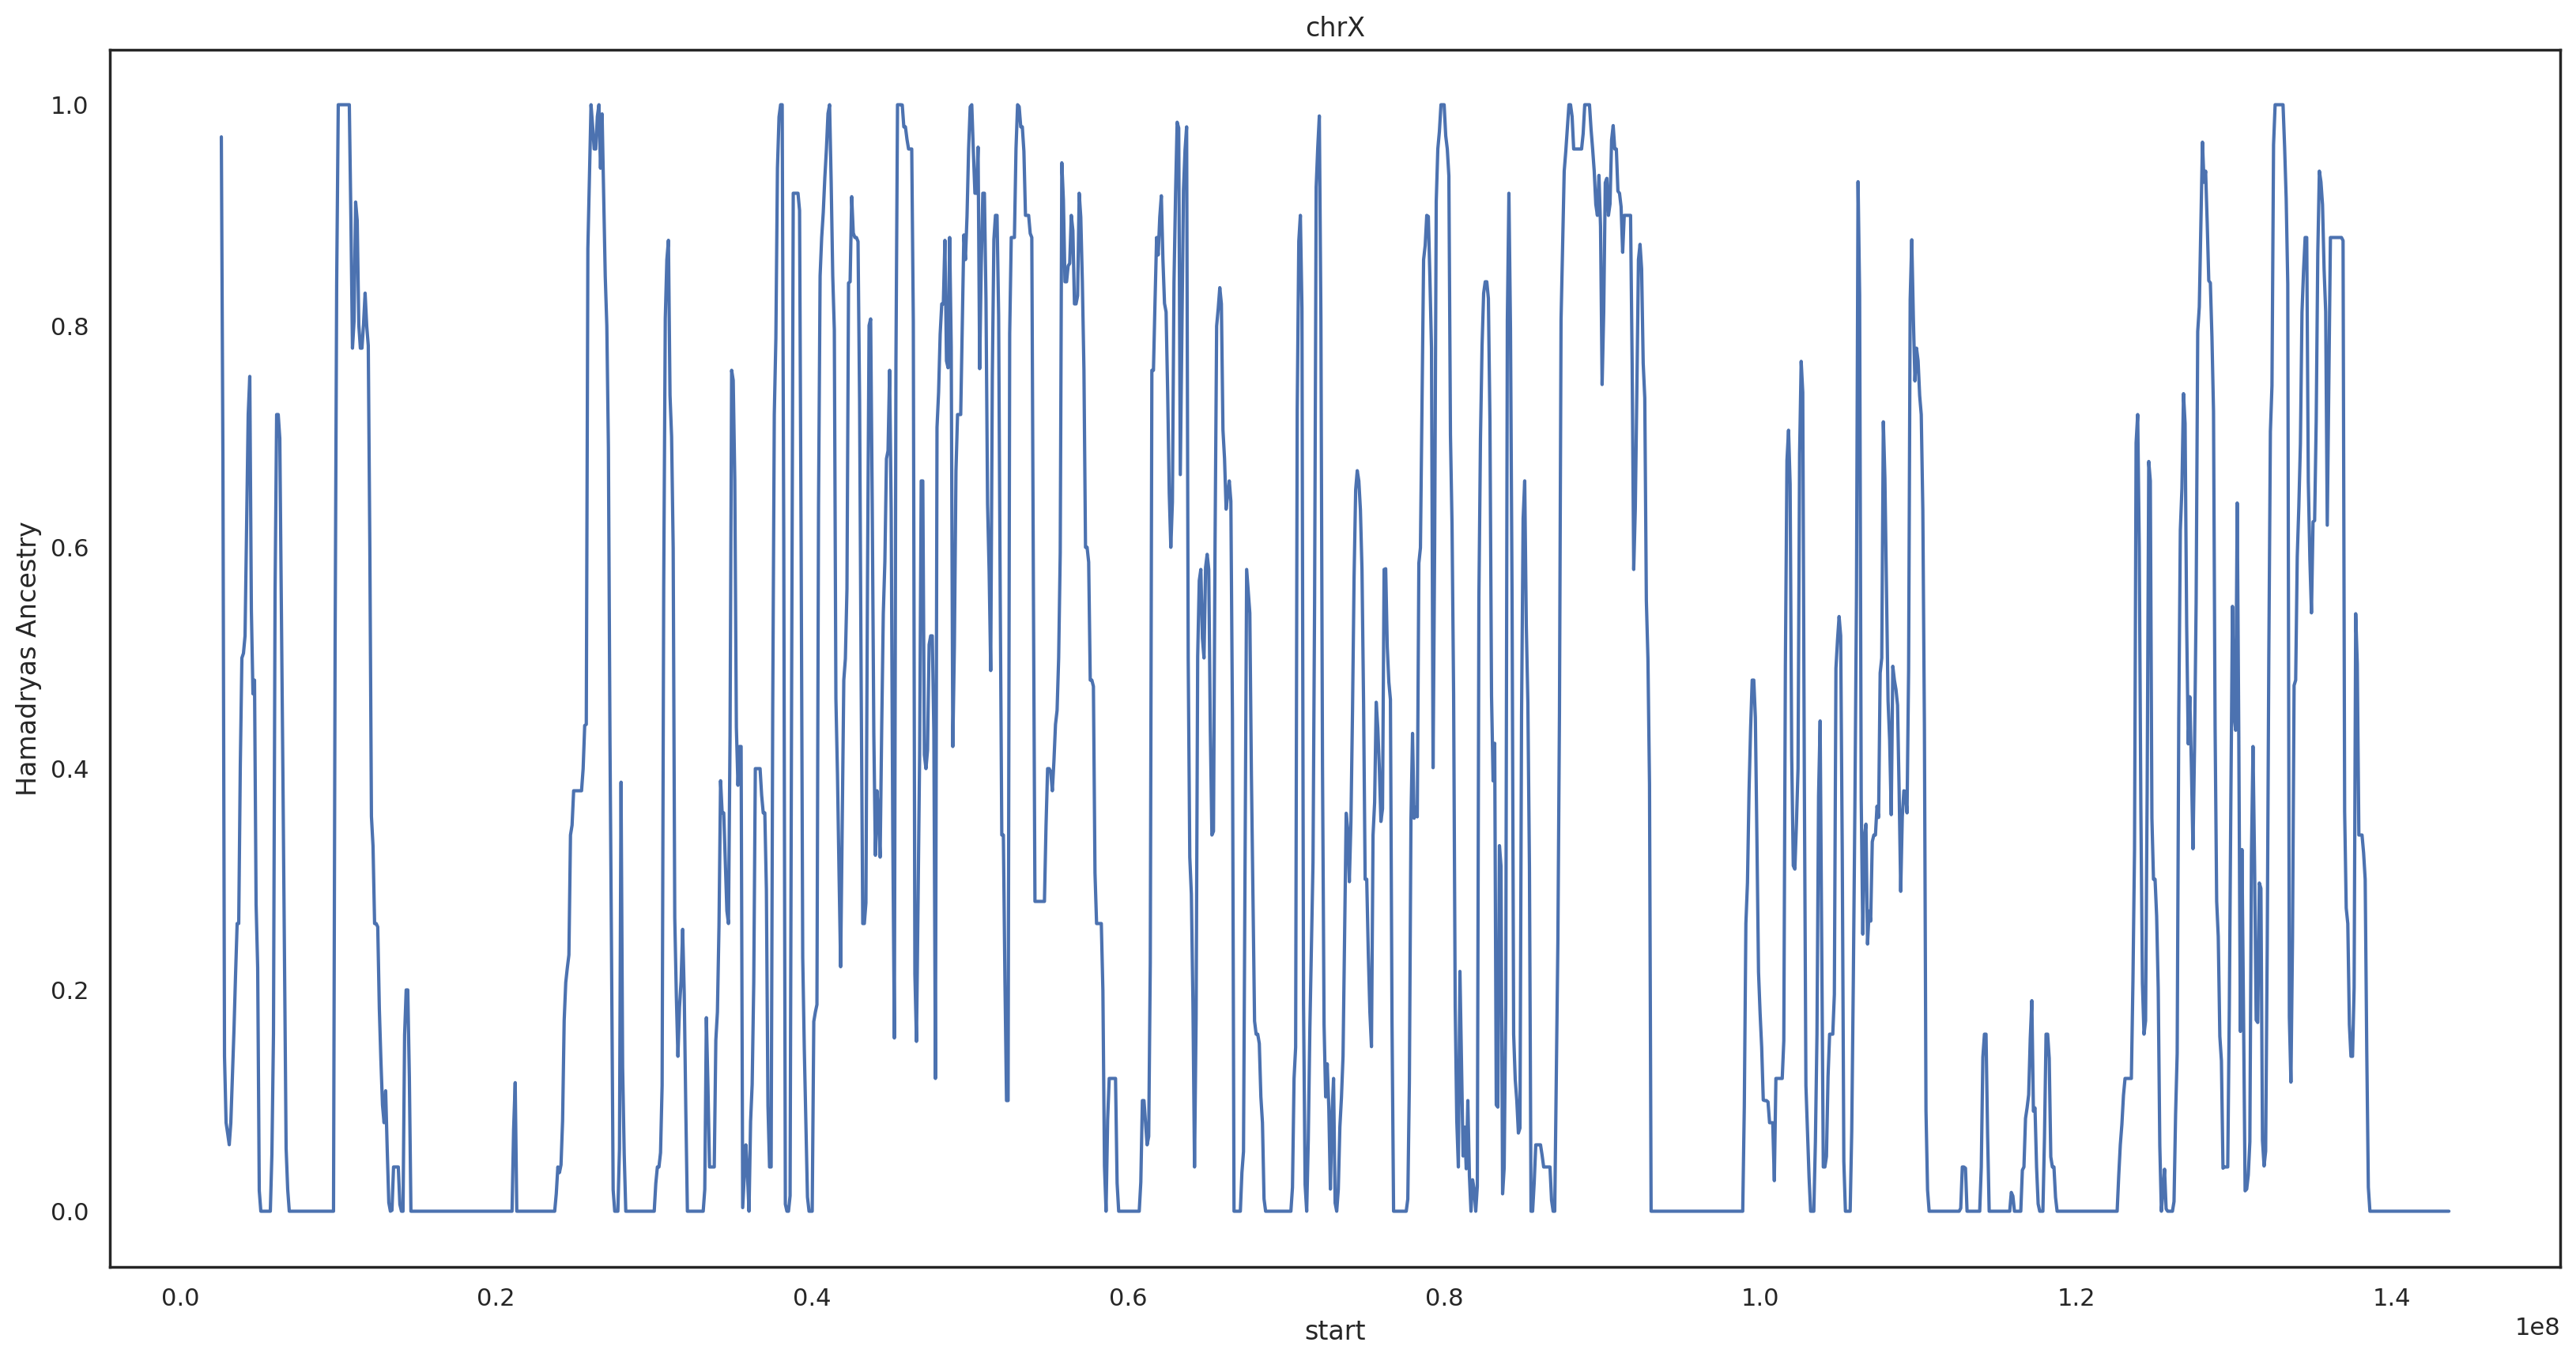

In [96]:
plt.figure(figsize=(20,10))
g = sns.lineplot(data=hamadryas_ancestry, x="start", y="Hamadryas Ancestry")
g.set_title("chrX")

/scratch/25307241/ipykernel_4052512/3830869676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["ancestry"] = ["olive" if x <= 25000 else "hamadryas" if x >= 75000


<Axes: xlabel='ancestry', ylabel='pi'>

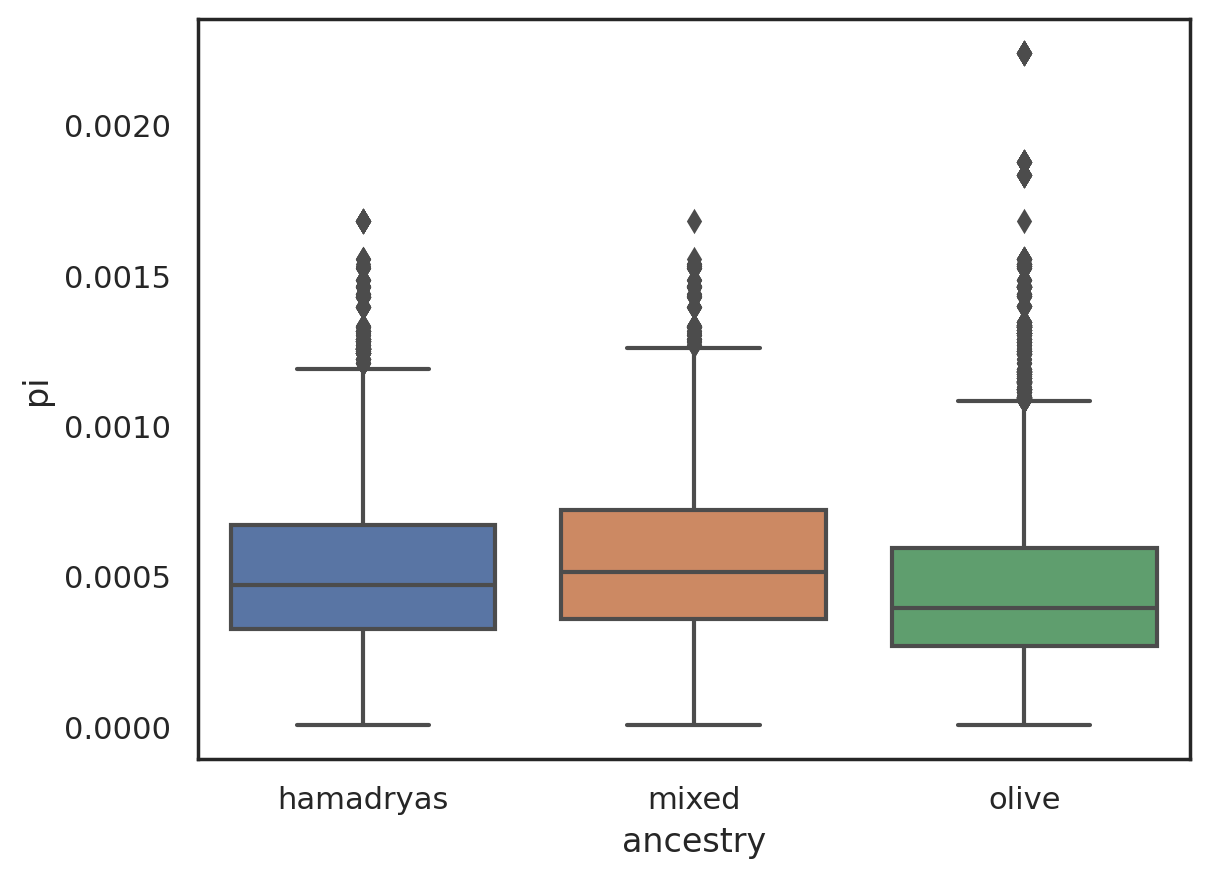

In [97]:
chr_df["ancestry"] = ["olive" if x <= 25000 else "hamadryas" if x >= 75000
                        else "mixed" for x in chr_df.north_sum]
sns.boxplot(data=chr_df, y="pi", x="ancestry")

<Axes: xlabel='ancestry', ylabel='donor_1_div'>

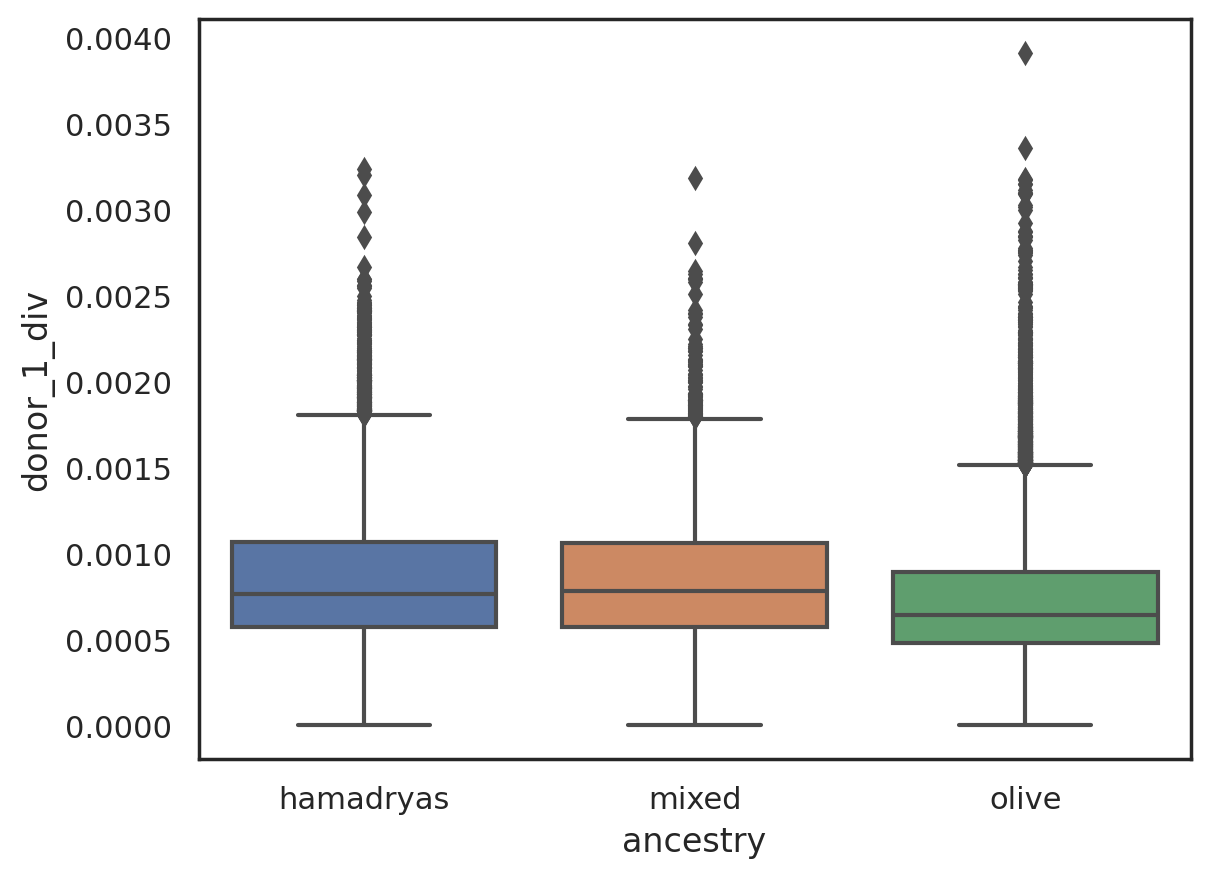

In [98]:
sns.boxplot(data=chr_df, y="donor_1_div", x="ancestry")

<Axes: xlabel='ancestry', ylabel='donor_2_div'>

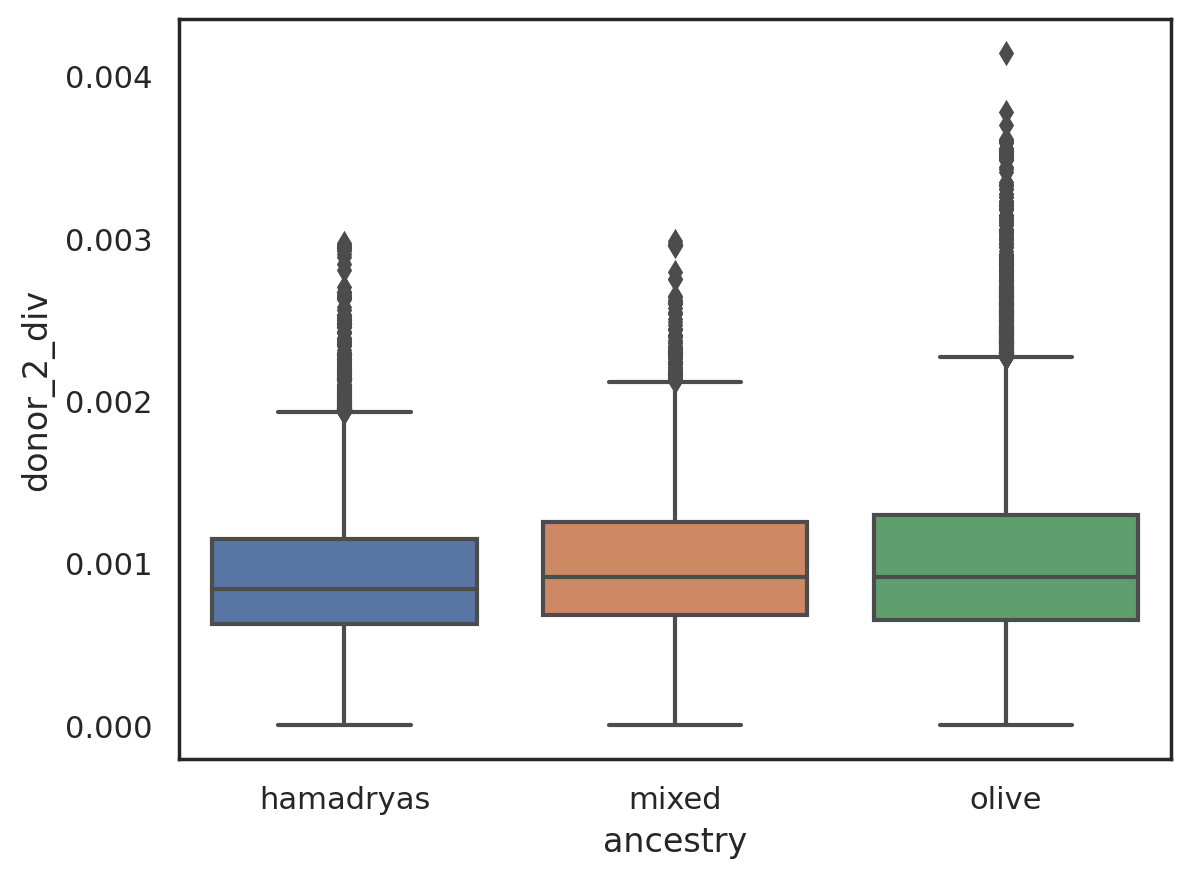

In [91]:
sns.boxplot(data=chr_df, y="donor_2_div", x="ancestry")

In [92]:
chr_df.loc[chr_df.ancestry == "hamadryas"].donor_2_div.mean()/chr_df.loc[chr_df.ancestry == "olive"].donor_2_div.mean()

0.9008650495937278

In [94]:
chr_df.loc[chr_df.ancestry == "olive"].donor_1_div.mean()/chr_df.loc[chr_df.ancestry == "hamadryas"].donor_1_div.mean()

0.8480395104902951

<Axes: xlabel='ancestry', ylabel='pbs'>

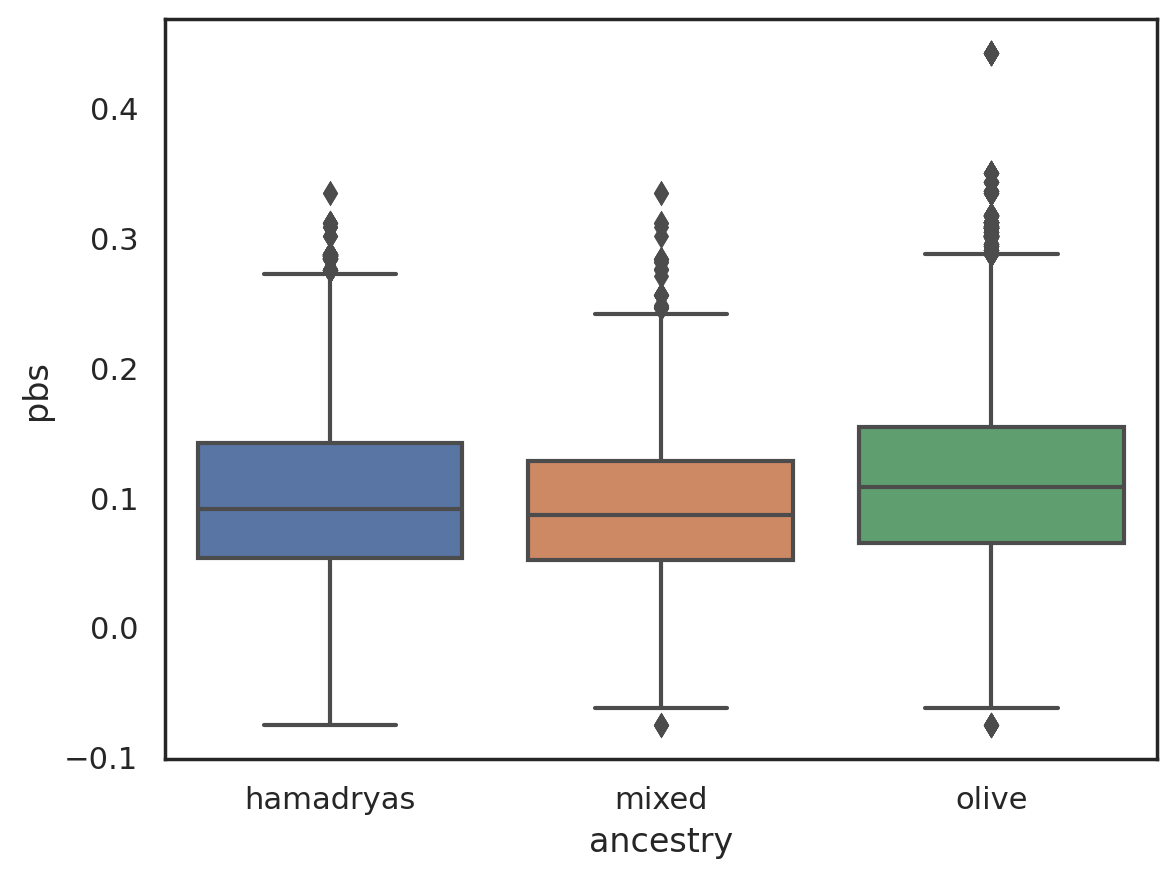

In [79]:
sns.boxplot(data=chr_df, y="pbs", x="ancestry")

<Axes: xlabel='ancestry', ylabel='average_cM_window'>

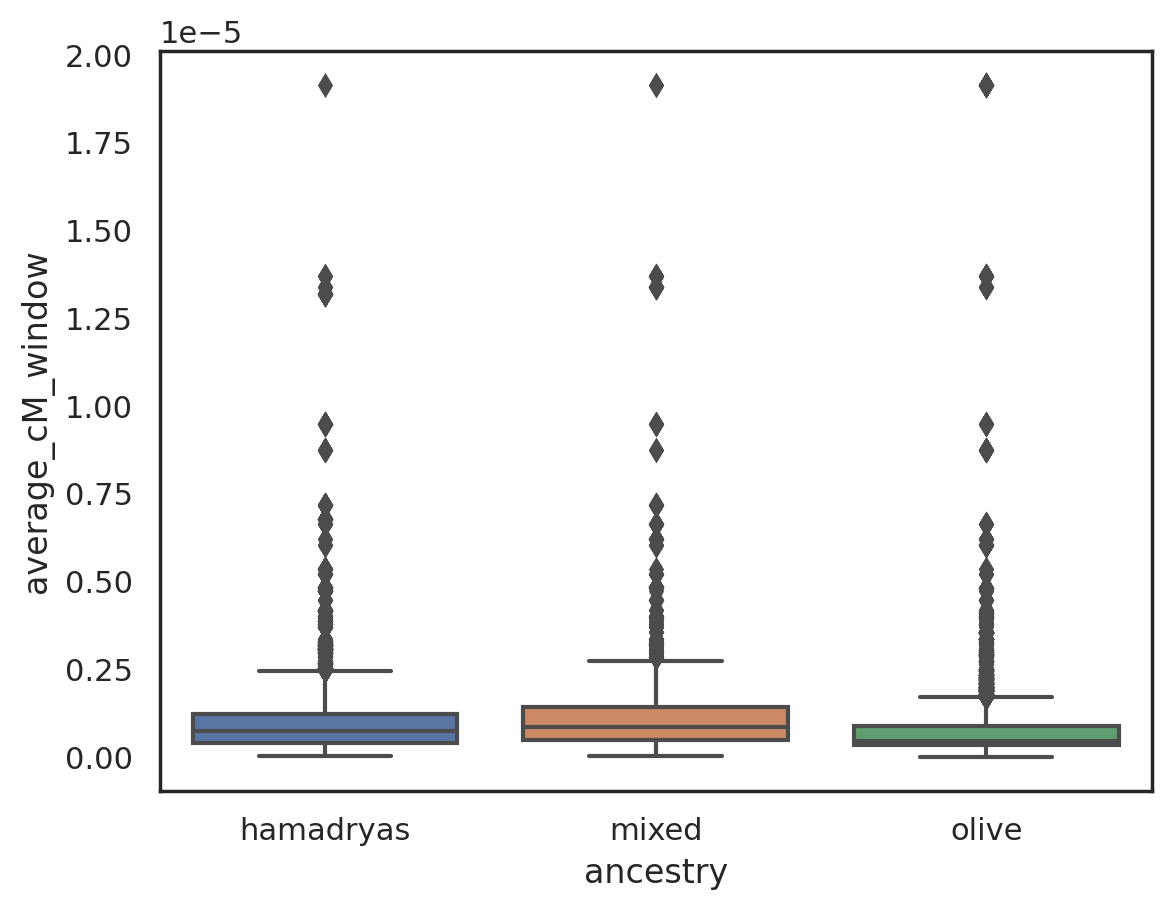

In [80]:
sns.boxplot(data=chr_df, y="average_cM_window", x="ancestry")

<Axes: xlabel='ancestry', ylabel='average_cM_window'>

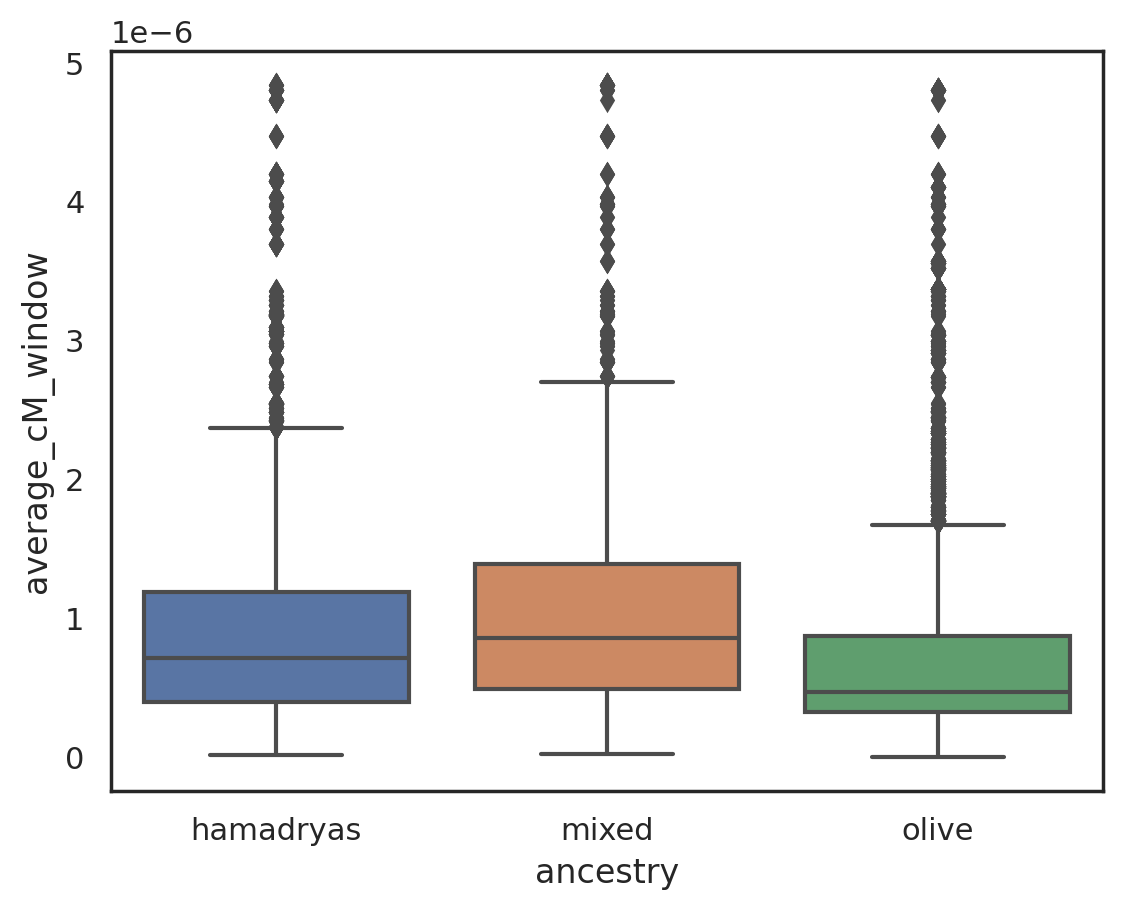

In [84]:
sns.boxplot(data=chr_df.loc[chr_df.average_cM_window < 0.000005], y="average_cM_window", x="ancestry")

In [81]:
chr_df.loc[chr_df.ancestry == "hamadryas"].average_cM_window.mean()/chr_df.loc[chr_df.ancestry == "olive"].average_cM_window.mean()

1.39609984684411

<Axes: xlabel='ancestry', ylabel='fst_2'>

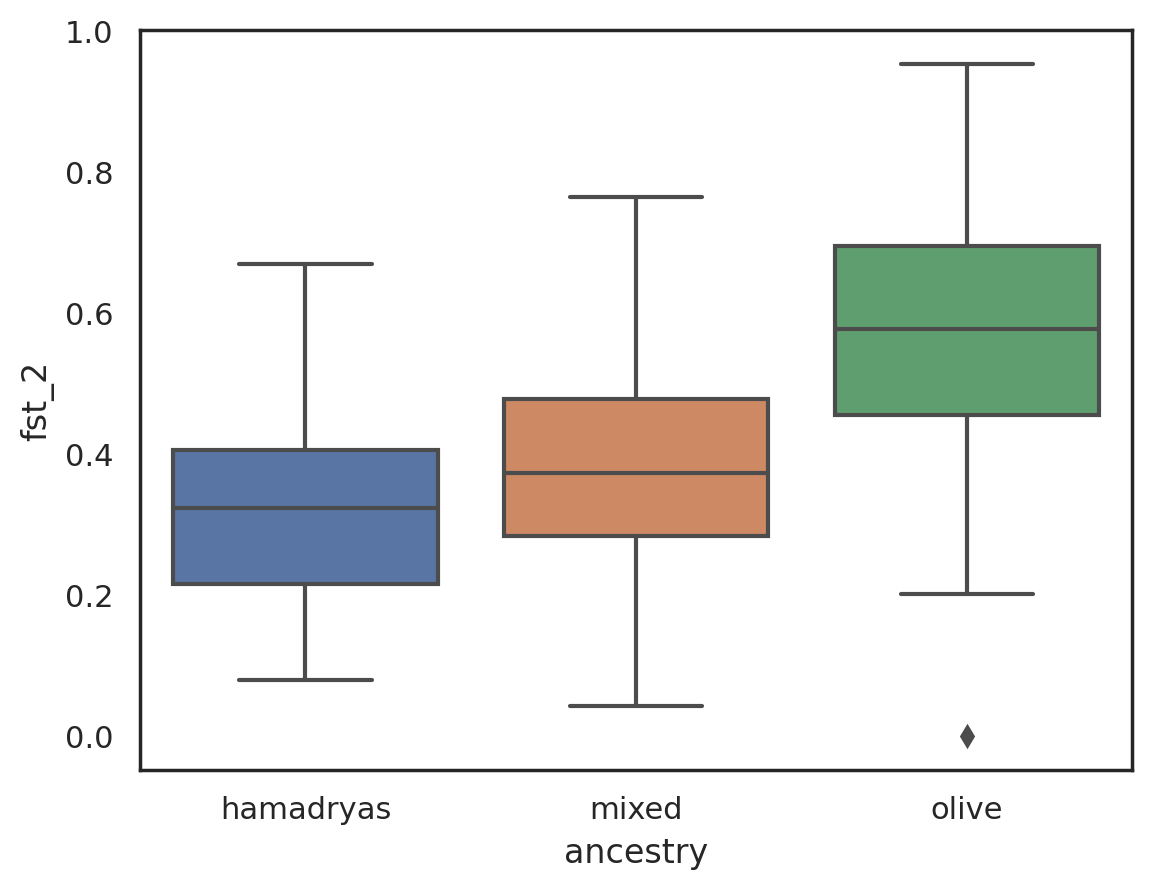

In [79]:
sns.boxplot(data=hamadryas_ancestry, y="fst_2", x="ancestry")

<Axes: xlabel='ancestry', ylabel='fst_1'>

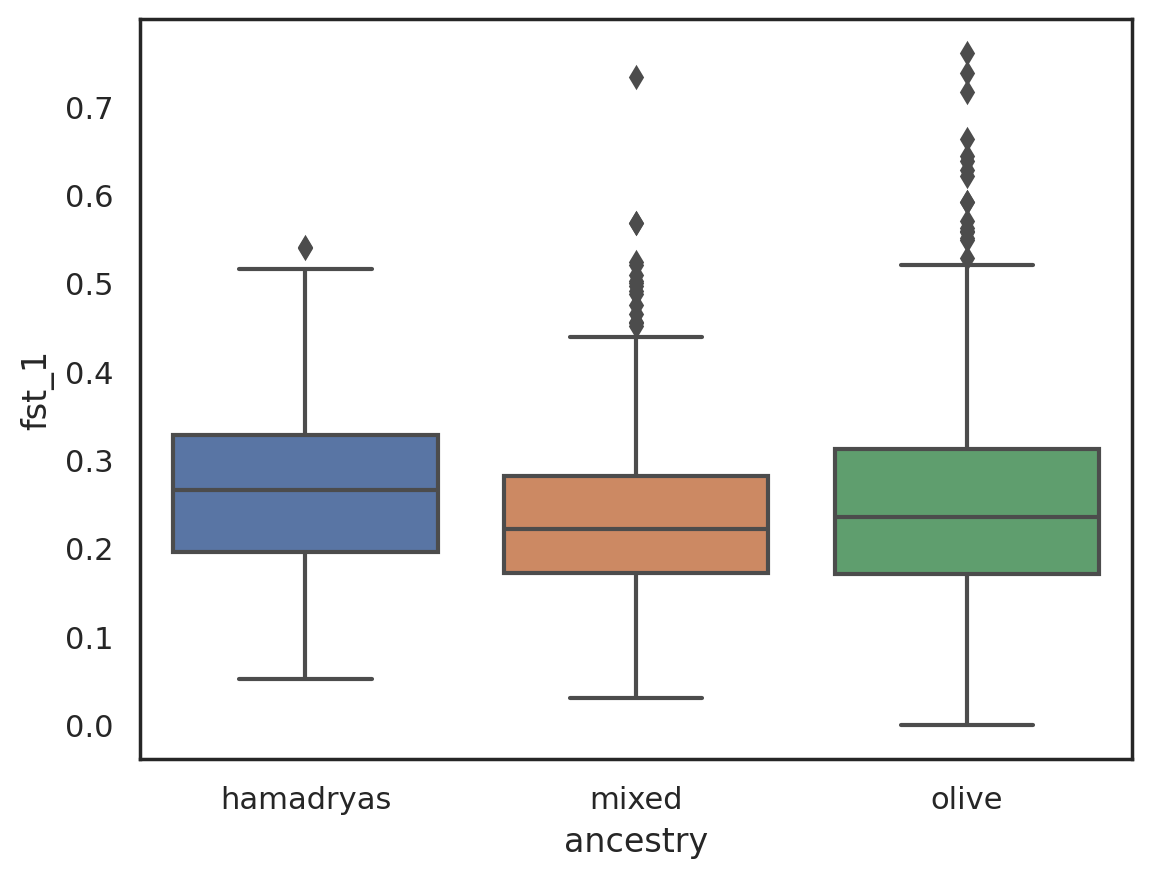

In [80]:
sns.boxplot(data=hamadryas_ancestry, y="fst_1", x="ancestry")

In [57]:
chr_df.loc[chr_df.ancestry == "hamadryas"].pi.mean()/chr_df.loc[chr_df.ancestry == "olive"].pi.mean()

1.1253763688820442

<Axes: xlabel='ancestry', ylabel='pi'>

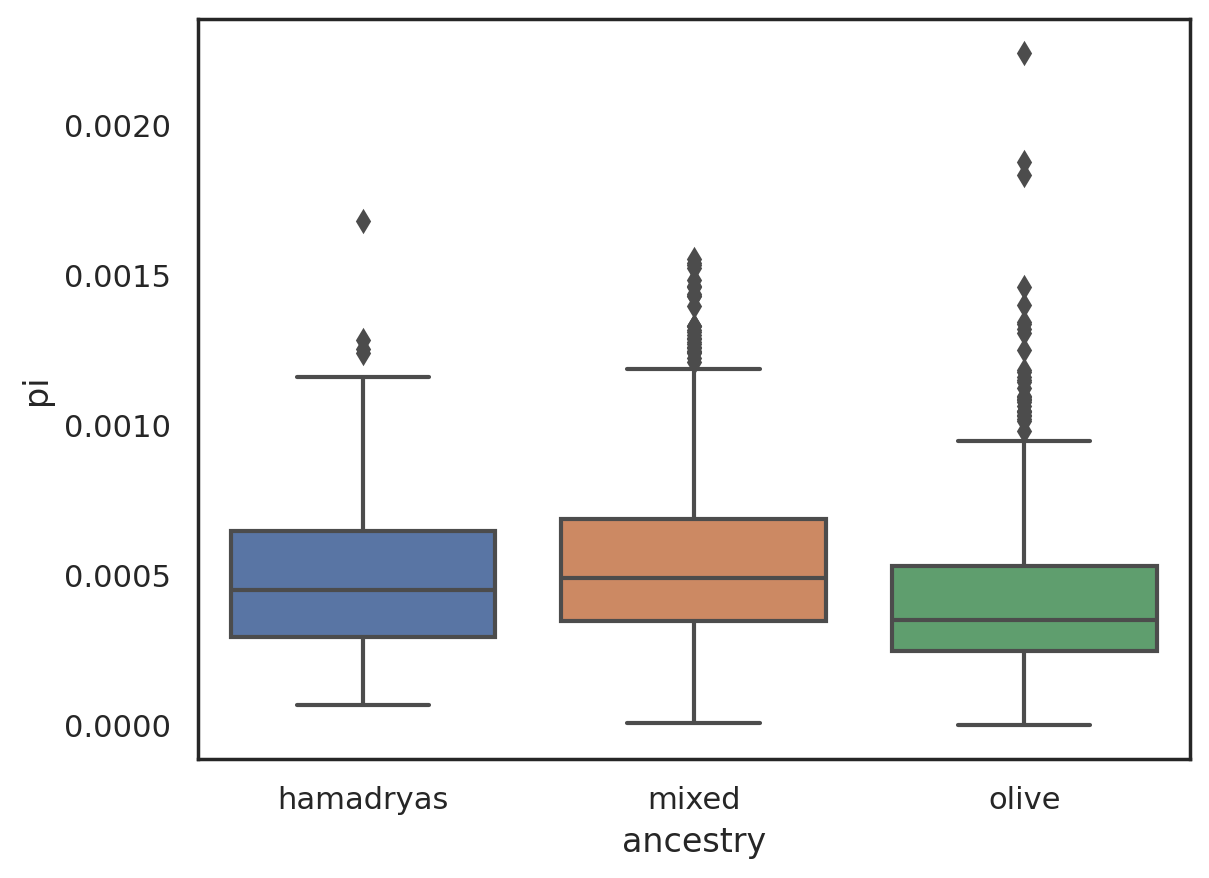

In [74]:
hamadryas_ancestry["ancestry"] = ["olive" if x <= 0.1 else "hamadryas" if x >= 0.9
                        else "mixed" for x in hamadryas_ancestry["Hamadryas Ancestry"]]
sns.boxplot(data=hamadryas_ancestry, y="pi", x="ancestry")

<Axes: xlabel='pi', ylabel='Count'>

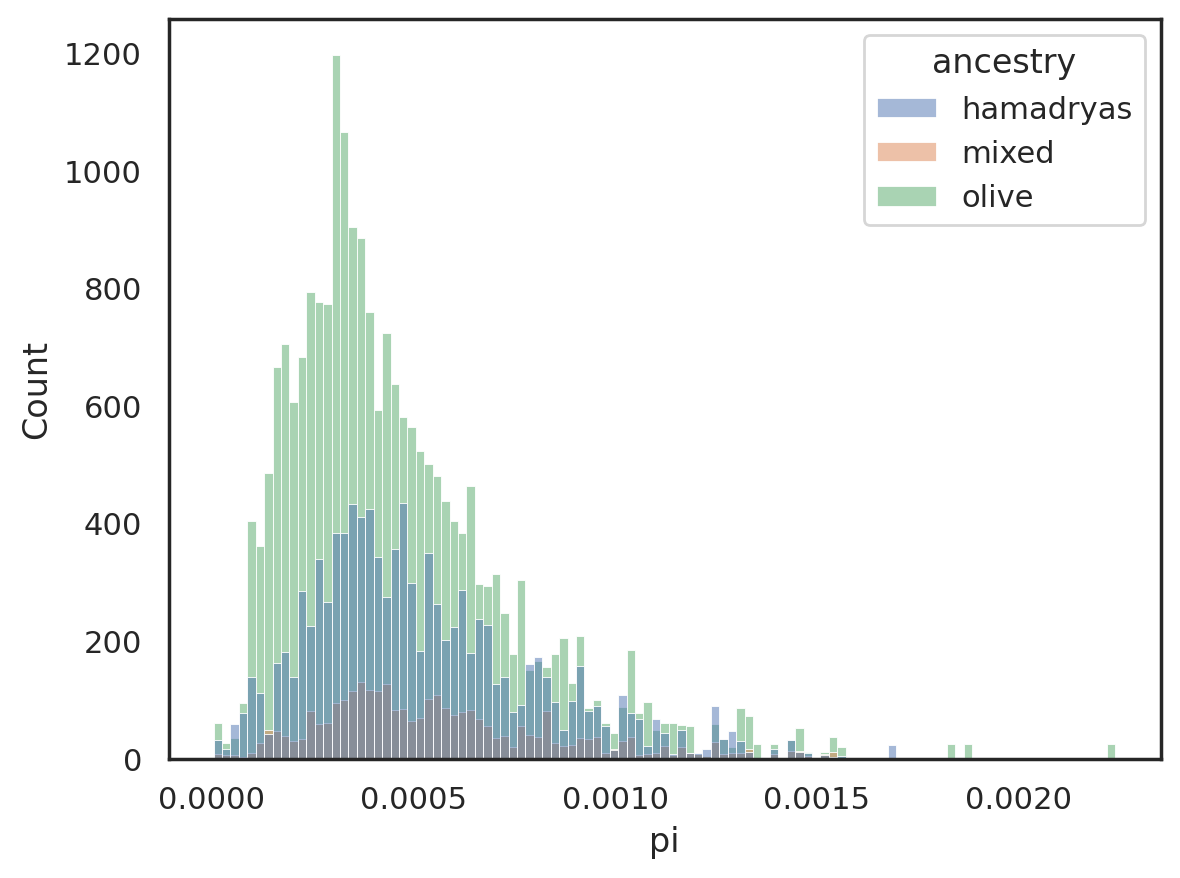

In [59]:
sns.histplot(data=chr_df, x="pi", hue="ancestry", multiple="layer")

Selection and its interaction with admixture

In [60]:
hamadryas_ancestry

,start,north_sum,callable_fraction,pi,pval,fst_1,fst_2,Hamadryas Ancestry,Callable,ancestry
0,2600000,97095.60,0.88629,0.000975,0.910153,0.287932,0.200988,0.970956,Uncalled,hamadryas
1,2700000,67927.98,0.73914,0.000809,1.242380,0.220464,0.210627,0.679280,Uncalled,mixed
2,2800000,14000.52,0.76499,0.000436,3.231310,0.240772,0.255178,0.140005,Uncalled,mixed
3,2900000,8000.00,0.79474,0.000649,1.627560,0.222688,0.268395,0.080000,Uncalled,olive
4,3000000,7035.50,0.45950,0.000259,1.467170,0.272908,0.219569,0.070355,Uncalled,olive
...,...,...,...,...,...,...,...,...,...,...
1406,143200000,0.00,0.66998,0.000056,1.484060,0.398961,0.843915,0.000000,Uncalled,olive
1407,143300000,0.00,0.90454,0.000072,1.823430,0.410571,0.837637,0.000000,Callable,olive
1408,143400000,0.00,0.79245,0.000104,2.502740,0.372976,0.741526,0.000000,Uncalled,olive
1409,143500000,0.00,0.88158,0.000107,2.502740,0.339139,0.784246,0.000000,Uncalled,olive


<Axes: xlabel='ancestry', ylabel='pval'>

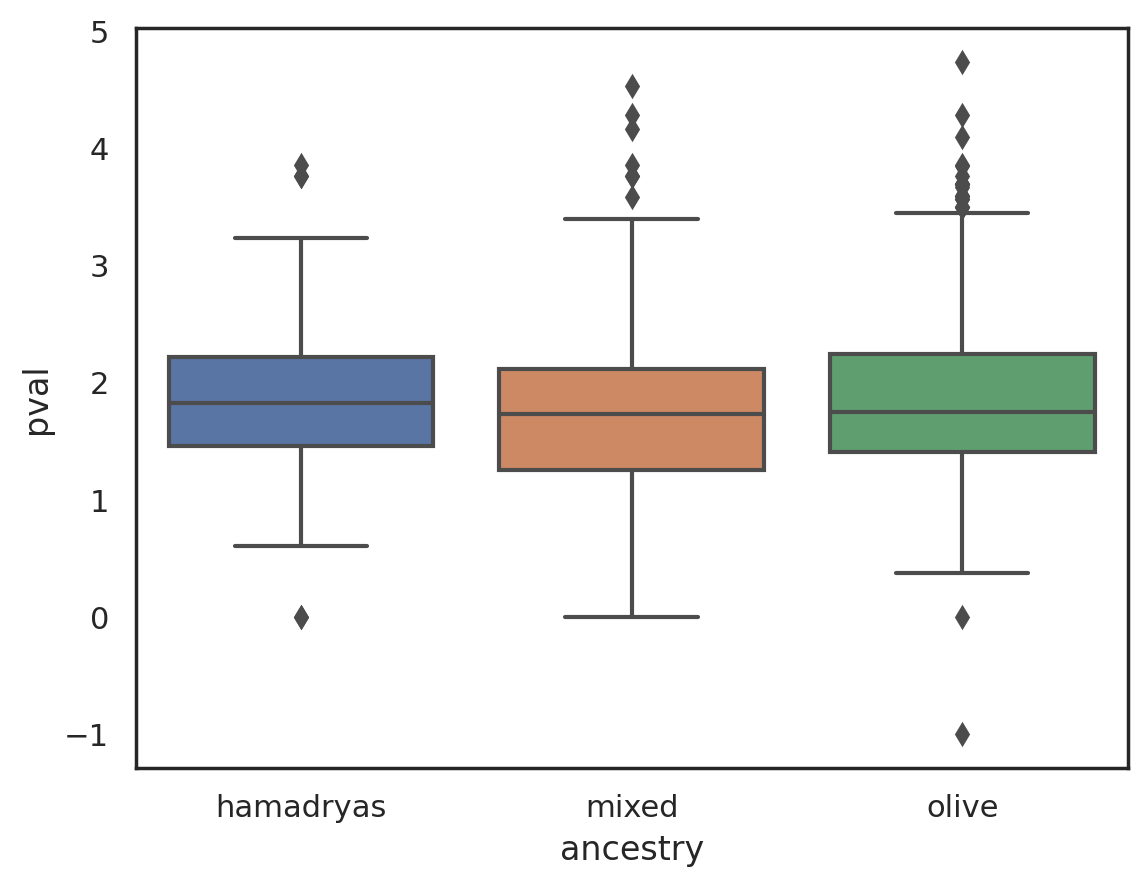

In [61]:
sns.boxplot(data=hamadryas_ancestry, y="pval", x="ancestry")

<Axes: xlabel='Hamadryas Ancestry', ylabel='pval'>

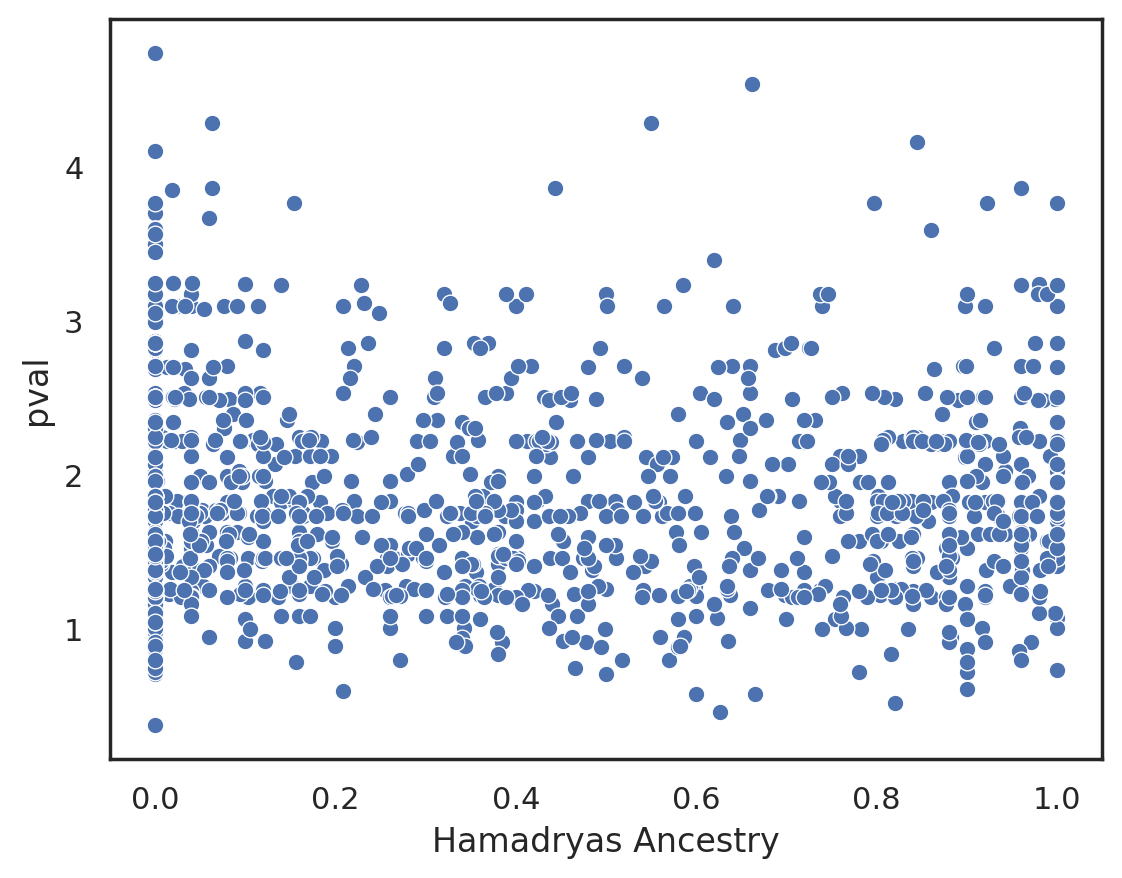

In [62]:
sns.scatterplot(data=hamadryas_ancestry.loc[hamadryas_ancestry.pval > 0], y="pval", x="Hamadryas Ancestry")

In [63]:
hamadryas_ancestry.loc[hamadryas_ancestry.pval < 0] = 0

In [64]:
hamadryas_ancestry

,start,north_sum,callable_fraction,pi,pval,fst_1,fst_2,Hamadryas Ancestry,Callable,ancestry
0,2600000,97095.60,0.88629,0.000975,0.910153,0.287932,0.200988,0.970956,Uncalled,hamadryas
1,2700000,67927.98,0.73914,0.000809,1.242380,0.220464,0.210627,0.679280,Uncalled,mixed
2,2800000,14000.52,0.76499,0.000436,3.231310,0.240772,0.255178,0.140005,Uncalled,mixed
3,2900000,8000.00,0.79474,0.000649,1.627560,0.222688,0.268395,0.080000,Uncalled,olive
4,3000000,7035.50,0.45950,0.000259,1.467170,0.272908,0.219569,0.070355,Uncalled,olive
...,...,...,...,...,...,...,...,...,...,...
1406,143200000,0.00,0.66998,0.000056,1.484060,0.398961,0.843915,0.000000,Uncalled,olive
1407,143300000,0.00,0.90454,0.000072,1.823430,0.410571,0.837637,0.000000,Callable,olive
1408,143400000,0.00,0.79245,0.000104,2.502740,0.372976,0.741526,0.000000,Uncalled,olive
1409,143500000,0.00,0.88158,0.000107,2.502740,0.339139,0.784246,0.000000,Uncalled,olive


In [107]:
h_sub = hamadryas_ancestry.loc[hamadryas_ancestry.start >= 5000000]

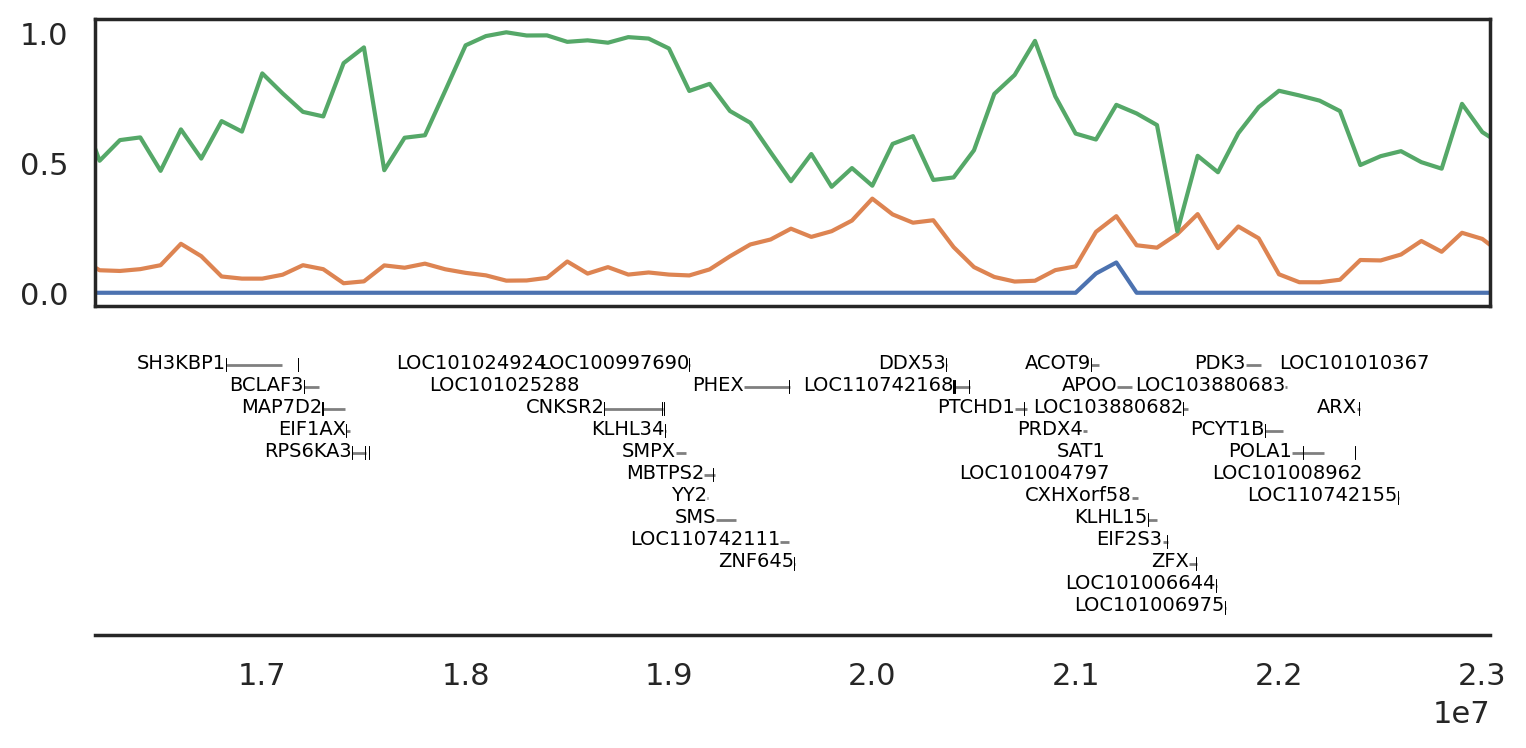

In [114]:
ax = gi.gene_plot('chrX', 17000000, 23000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
ax.plot(h_sub.start, h_sub["Hamadryas Ancestry"])
ax.plot(h_sub.start, h_sub.pi/h_sub.pi.max())
#ax.plot(h_sub.start, h_sub.fst_1/h_sub.fst_1.max()) # Olive fst
ax.plot(h_sub.start, h_sub.fst_2/h_sub.fst_2.max()) # Hamadryas fst
# ax.plot(h_sub.start, h_sub.pval/h_sub.pval.max()) pval from Relate

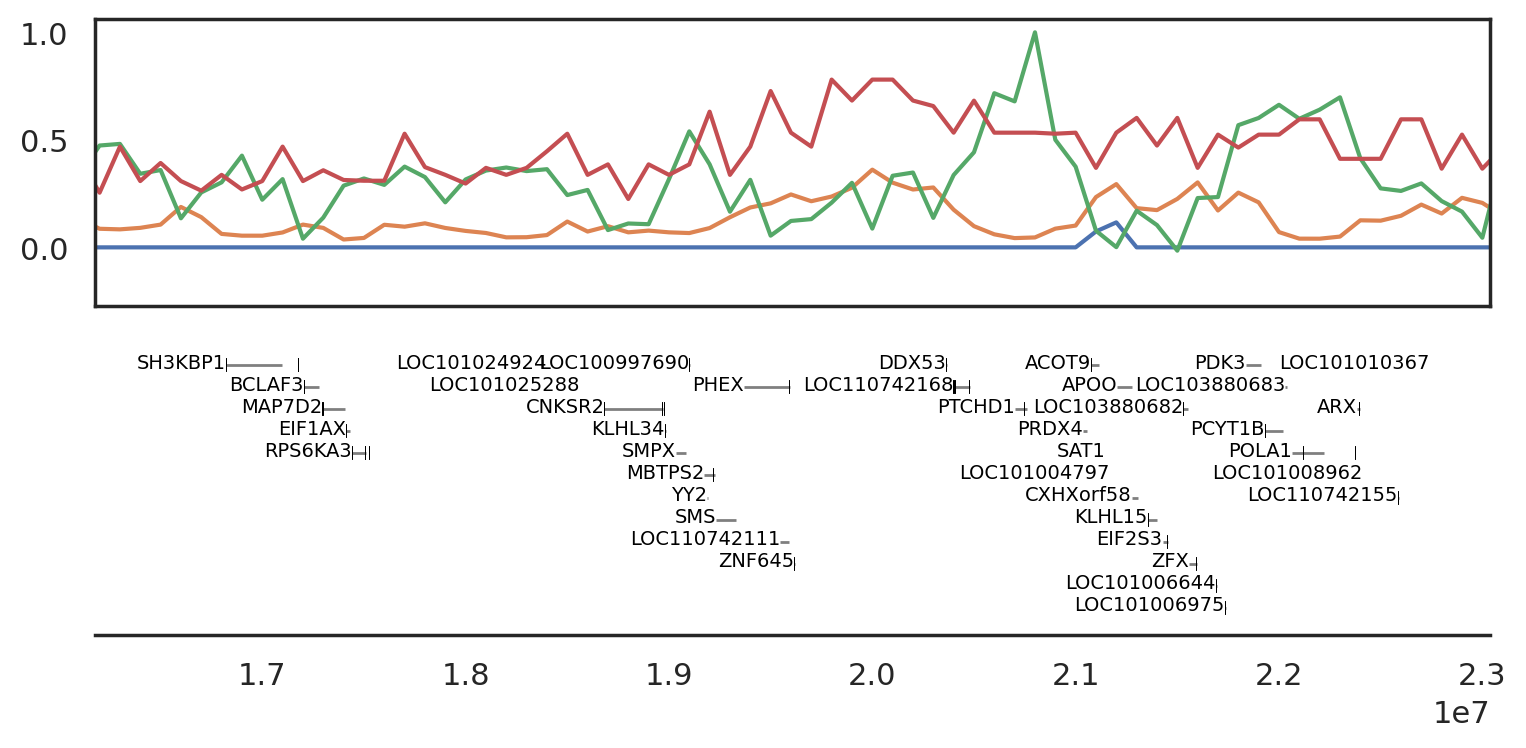

In [115]:
ax = gi.gene_plot('chrX', 17000000, 23000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
ax.plot(h_sub.start, h_sub["Hamadryas Ancestry"])

ax.plot(h_sub.start, h_sub.pi/h_sub.pi.max())
ax.plot(h_sub.start, h_sub.pbs/h_sub.pbs.max()) # Hamadryas fst
ax.plot(h_sub.start, h_sub.pval/h_sub.pval.max()) #pval from Relate

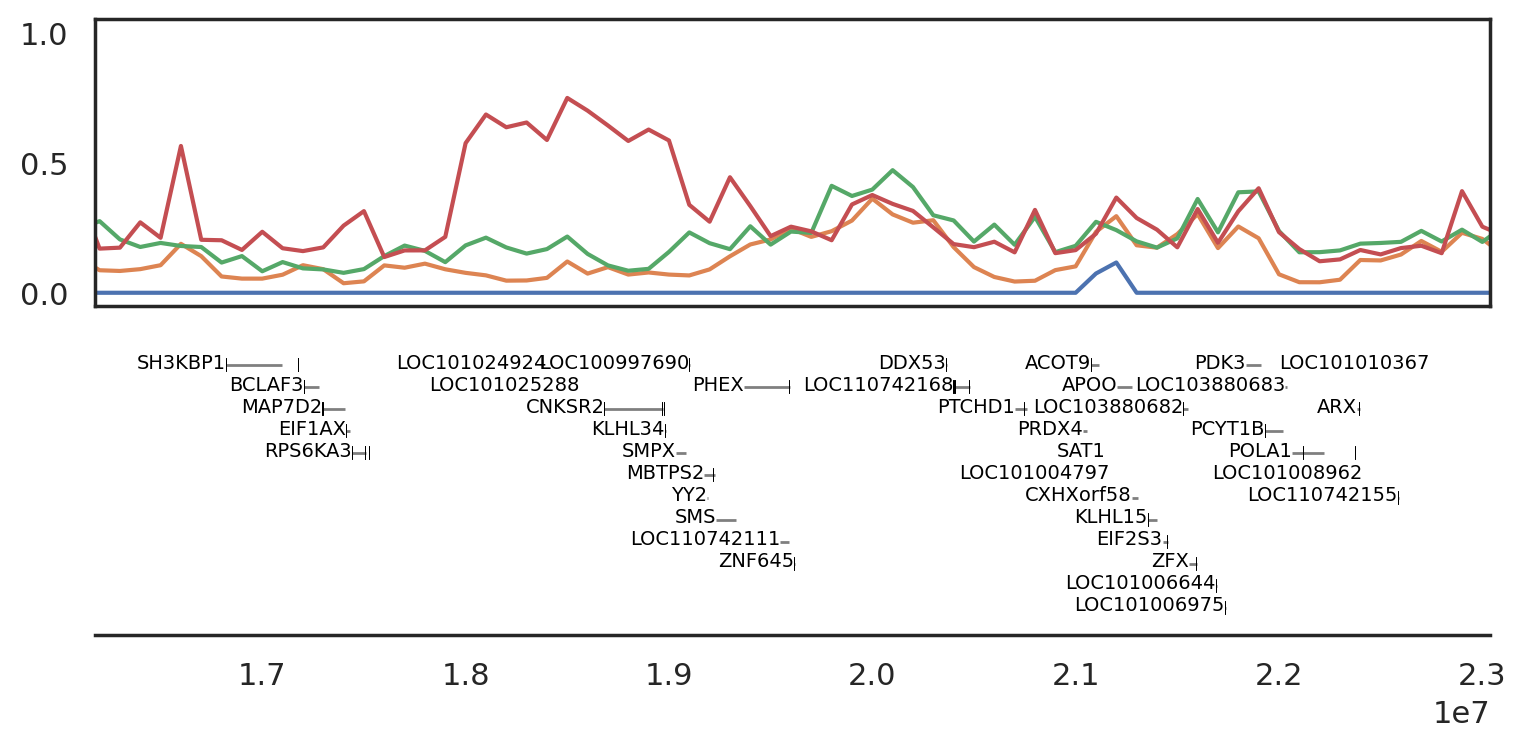

In [116]:
ax = gi.gene_plot('chrX', 17000000, 23000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
ax.plot(h_sub.start, h_sub["Hamadryas Ancestry"])

ax.plot(h_sub.start, h_sub.pi/h_sub.pi.max())
ax.plot(h_sub.start, h_sub.donor_1_div/h_sub.donor_1_div.max()) # Olive divergence
ax.plot(h_sub.start, h_sub.donor_2_div/h_sub.donor_2_div.max()) # Hamadryas divergence

<Axes: xlabel='start', ylabel='donor_1_div'>

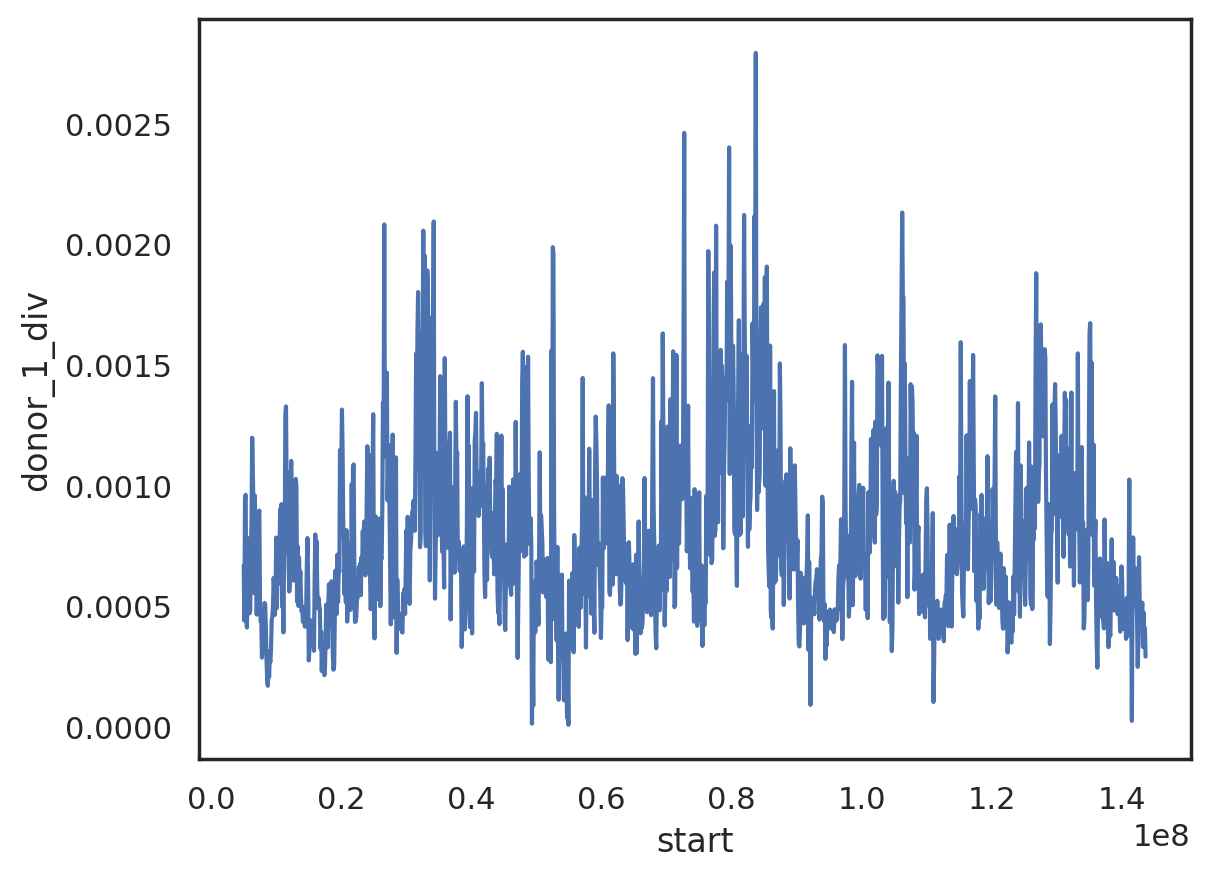

In [111]:
sns.lineplot(data=h_sub, x="start", y="donor_1_div")

<Axes: xlabel='start', ylabel='donor_2_div'>

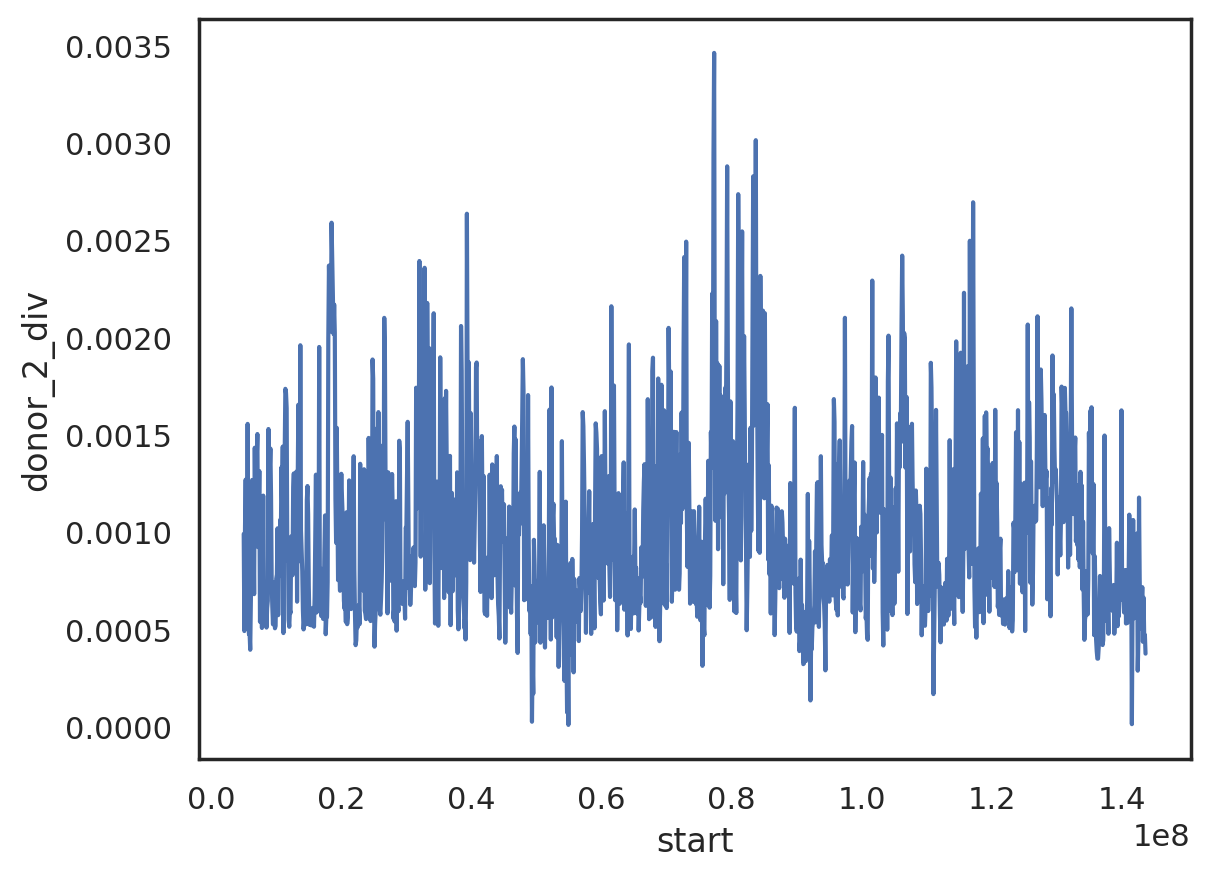

In [110]:
sns.lineplot(data=h_sub, x="start", y="donor_2_div")

/scratch/25307241/ipykernel_4052512/4216861174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_sub["div_ratio"] = h_sub.donor_1_div /(h_sub.donor_2_div+h_sub.donor_1_div)


<Axes: xlabel='start', ylabel='div_ratio'>

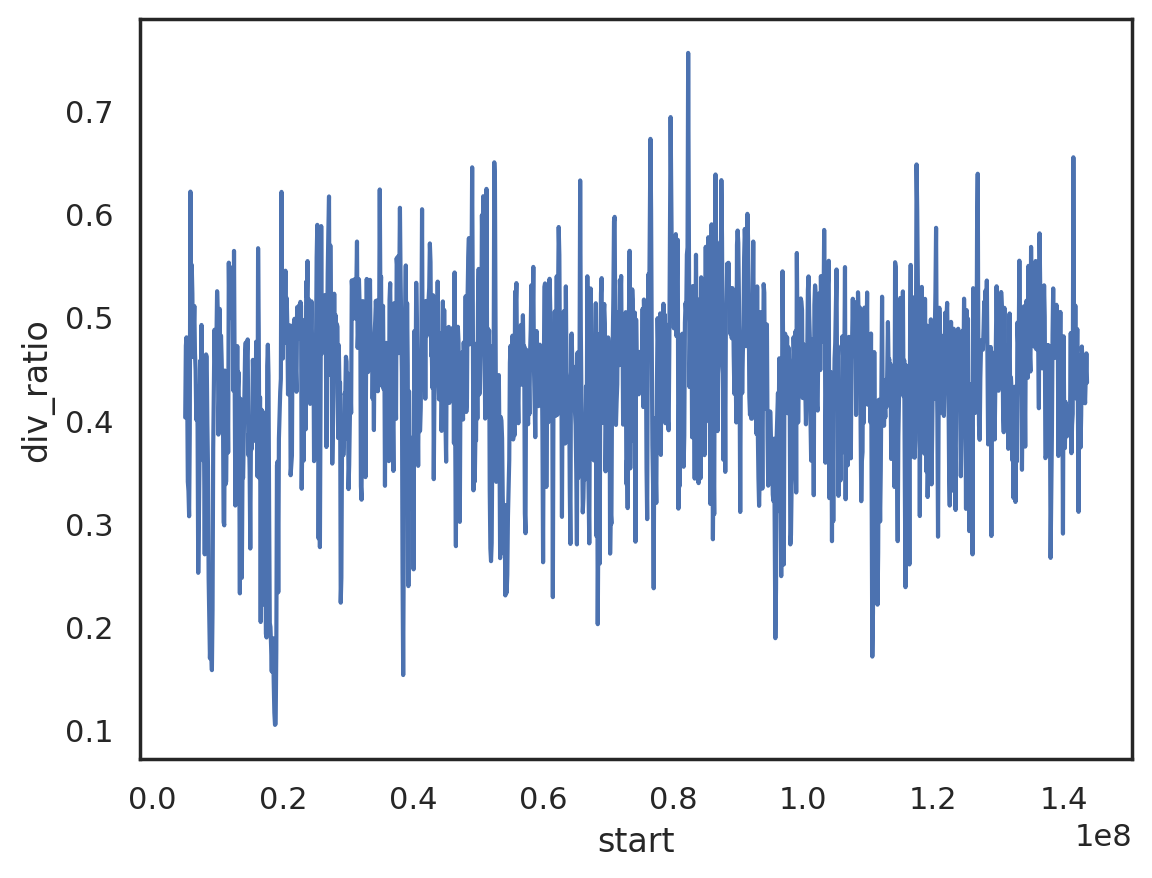

In [112]:
h_sub["div_ratio"] = h_sub.donor_1_div /(h_sub.donor_2_div+h_sub.donor_1_div)
sns.lineplot(data=h_sub, x="start", y="div_ratio")

/scratch/25307241/ipykernel_4052512/1249070670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_sub["div_ratio"] = h_sub.donor_2_div /(h_sub.donor_2_div+h_sub.donor_1_div)


<Axes: xlabel='start', ylabel='div_ratio'>

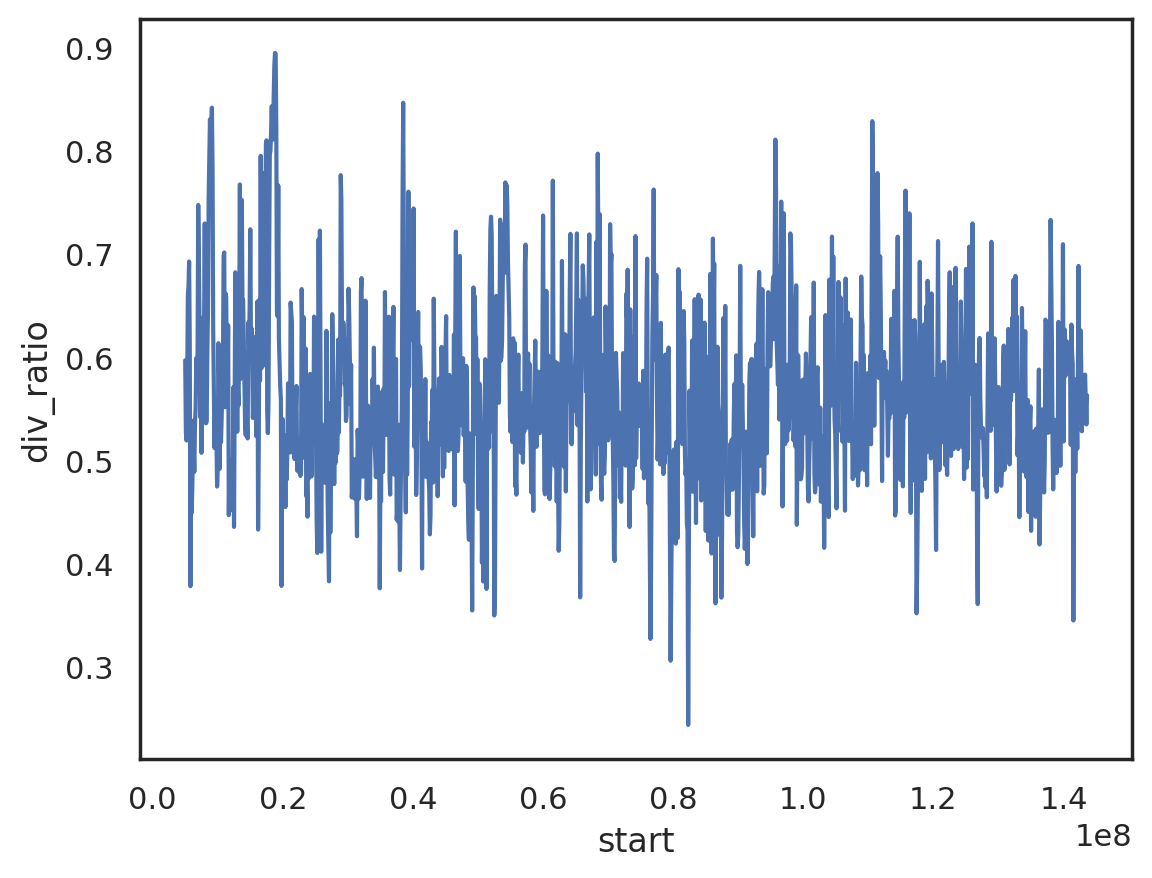

In [113]:
h_sub["div_ratio"] = h_sub.donor_2_div /(h_sub.donor_2_div+h_sub.donor_1_div)
sns.lineplot(data=h_sub, x="start", y="div_ratio")

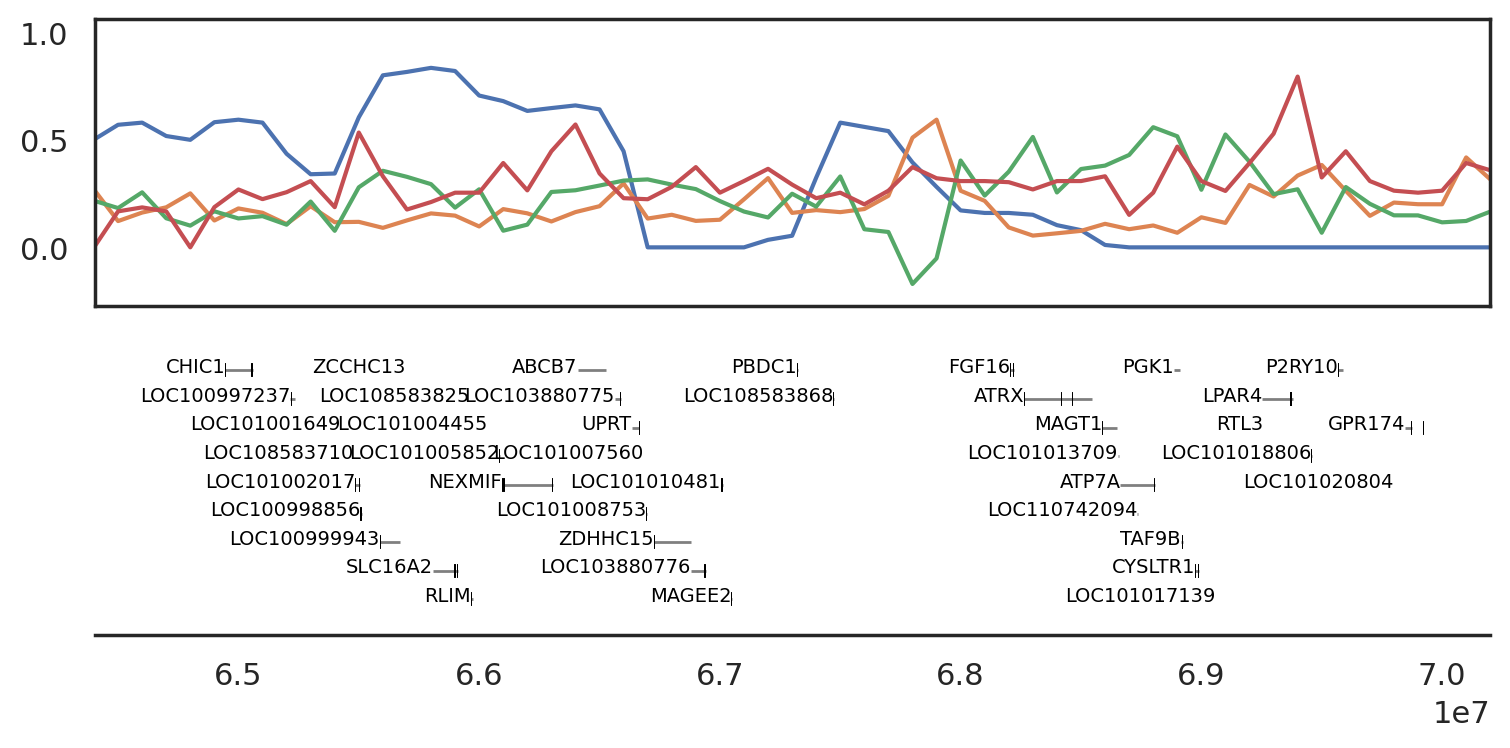

In [88]:
ax = gi.gene_plot('chrX', 65000000, 70000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
ax.plot(h_sub.start, h_sub["Hamadryas Ancestry"])

ax.plot(h_sub.start, h_sub.pi/h_sub.pi.max())
ax.plot(h_sub.start, h_sub.pbs/h_sub.pbs.max()) # Hamadryas fst
ax.plot(h_sub.start, h_sub.pval/h_sub.pval.max()) #pval from Relate

<Axes: xlabel='start', ylabel='pbs'>

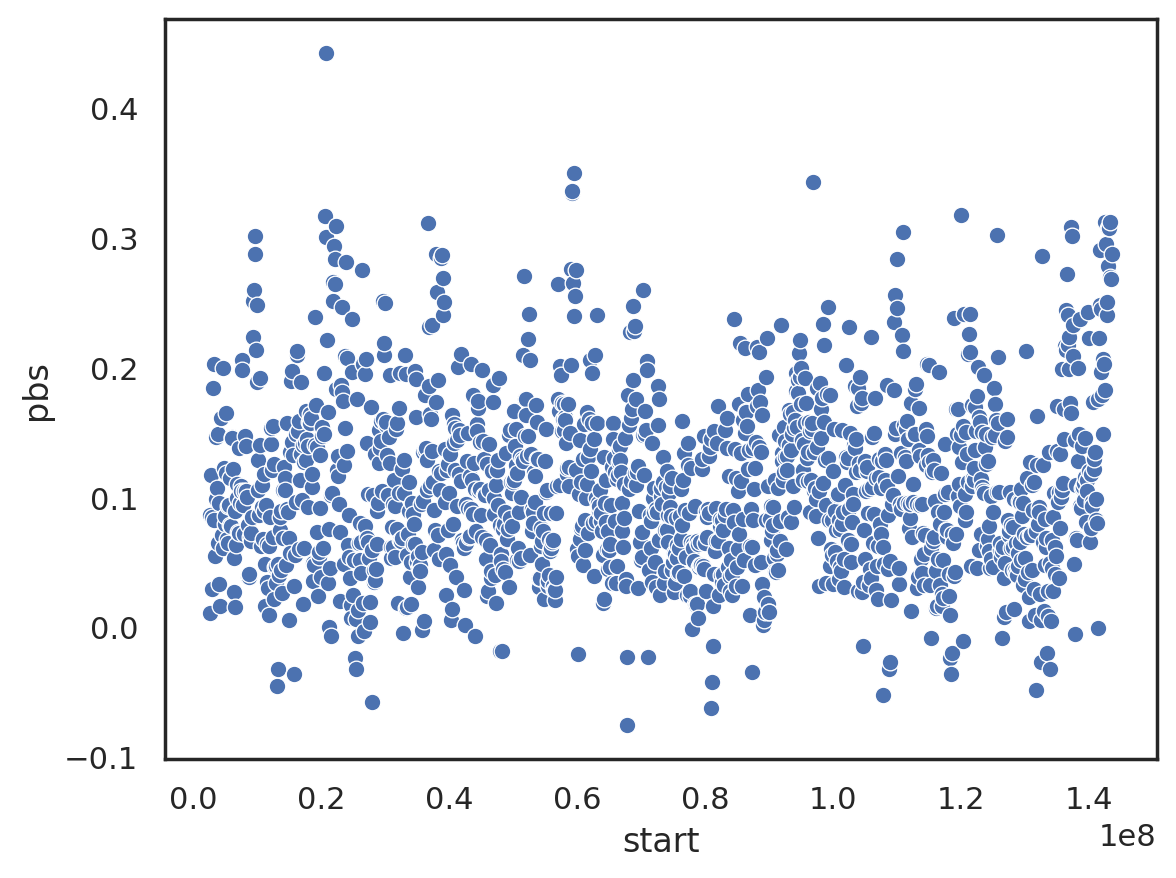

In [47]:
sns.scatterplot(data=hamadryas_ancestry, x="start", y="pbs")

<Axes: xlabel='start', ylabel='pval'>

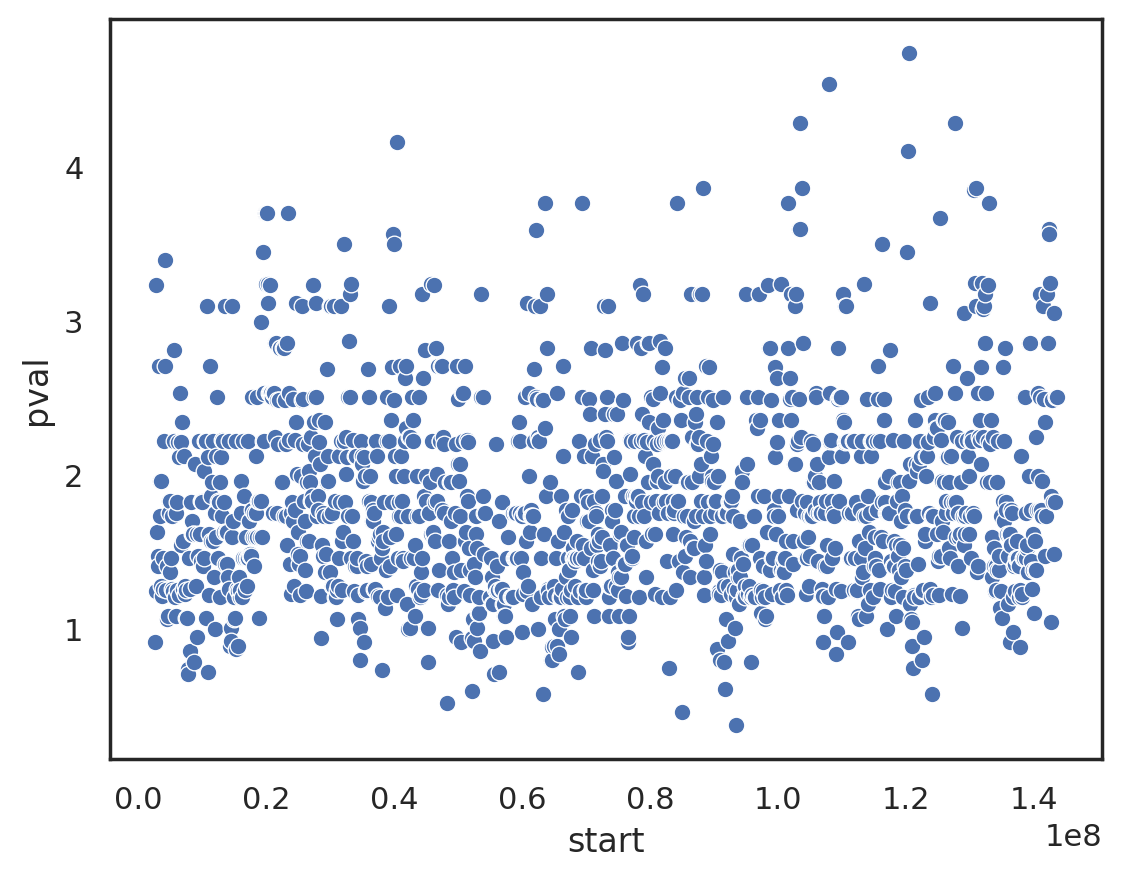

In [85]:
sns.scatterplot(data=hamadryas_ancestry.loc[hamadryas_ancestry.pval > 0], y="pval", x="start")

<Axes: xlabel='start', ylabel='pval'>

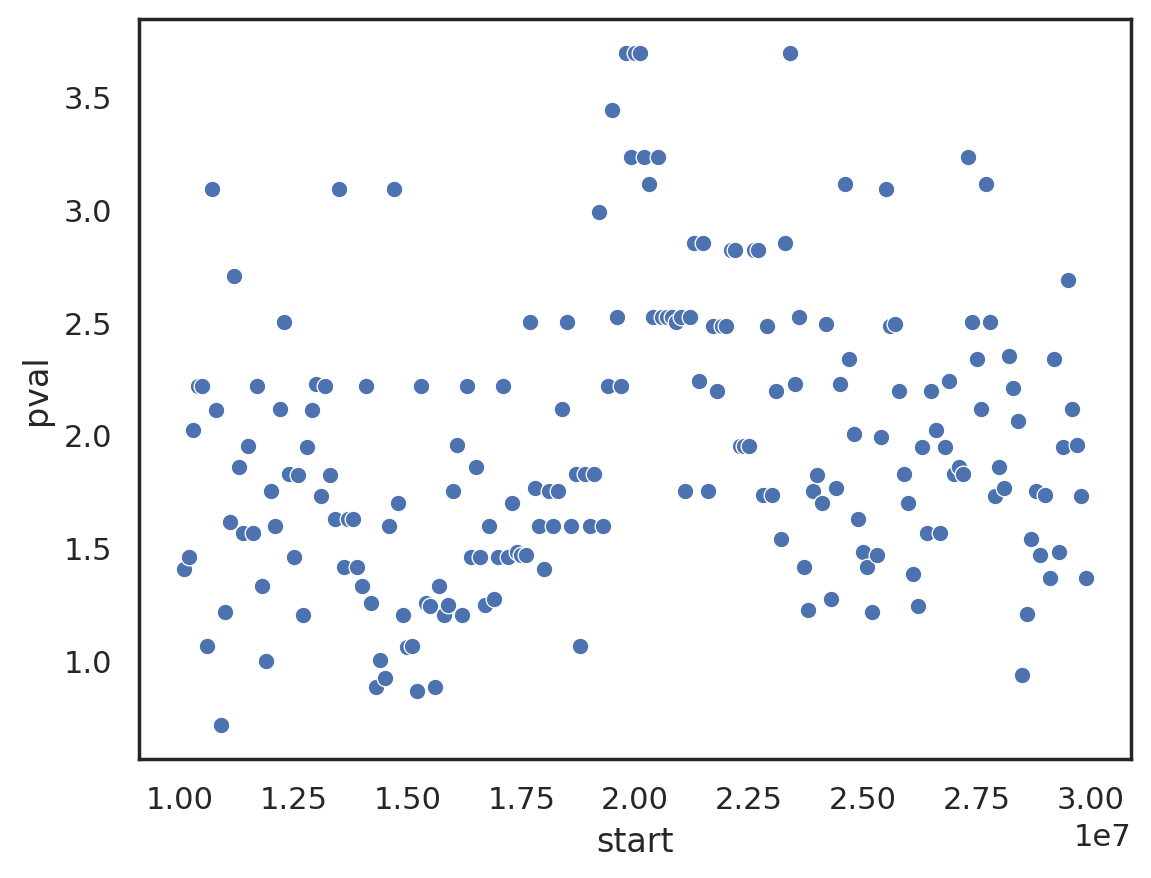

In [86]:
sns.scatterplot(data=hamadryas_ancestry.loc[(hamadryas_ancestry.pval > 0) &
                                           (hamadryas_ancestry.start > 10000000) &
                                           (hamadryas_ancestry.start < 30000000)], y="pval", x="start")

In [28]:
chr_df.loc[chr_df.ancestry == "olive"].pval.mean()/chr_df.loc[chr_df.ancestry == "hamadryas"].pval.mean()

1.024952628536233

In [29]:
hamadryas_ancestry.pval.max()

4.73639

In [30]:
hamadryas_ancestry.loc[hamadryas_ancestry.pval > 4]

,start,north_sum,callable_fraction,pi,pval,Hamadryas Ancestry,Callable,ancestry
379,40500000,84531.58,1.01206,0.000574,4.15973,0.845316,Callable,mixed
1009,103500000,6285.60,0.94310,0.000213,4.28158,0.062856,Callable,olive
1053,107900000,66212.56,1.03248,0.000895,4.53135,0.662126,Callable,mixed
1177,120300000,0.00,0.97352,0.000765,4.09922,0.000000,Callable,olive
1178,120400000,0.00,1.02054,0.000359,4.73639,0.000000,Callable,olive
1250,127600000,55027.26,0.99271,0.000953,4.28158,0.550273,Callable,mixed


In [31]:
len(hamadryas_ancestry)

1411

In [32]:
len(mask_percentage), len(pval_list)

(1437, 1437)

<Axes: ylabel='Count'>

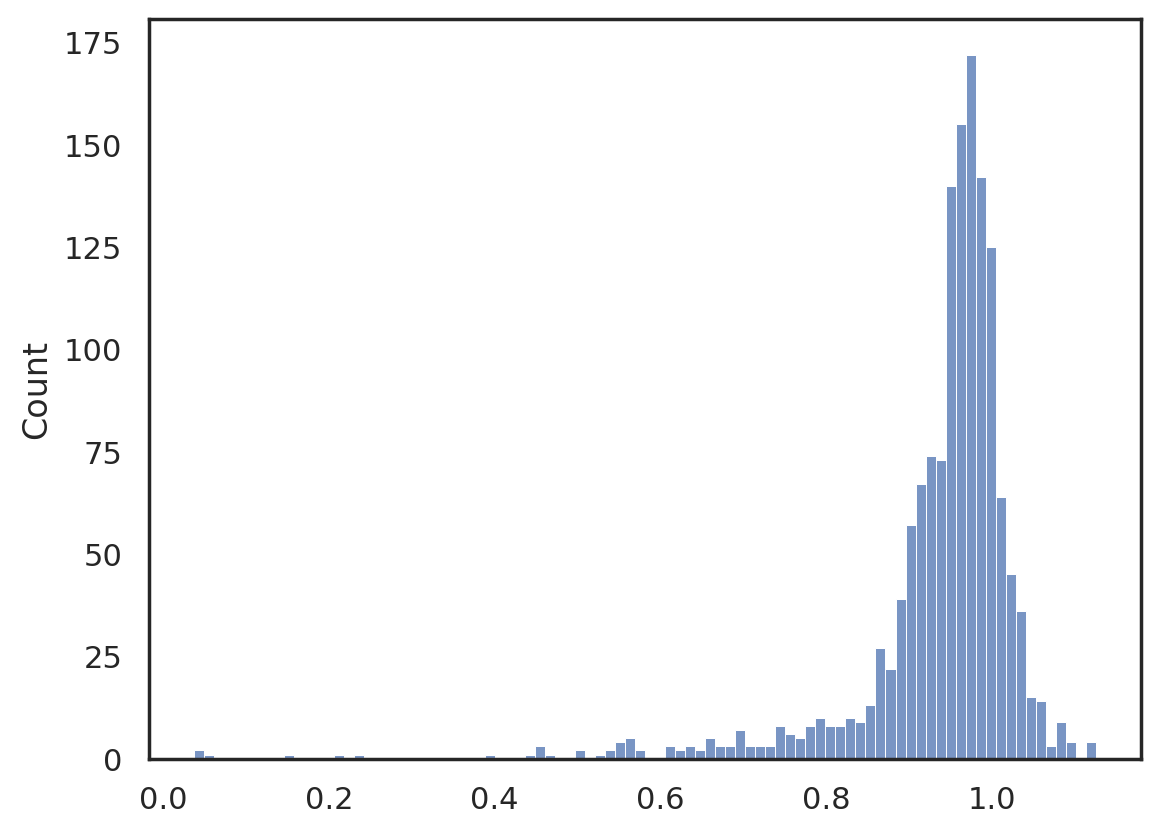

In [33]:
sns.histplot(mask_percentage)

In [34]:
sum(mask_percentage)/len(mask_percentage)

0.9380359151009043

Labeling for rfmix data

In [35]:
total_df.north_sum.value_counts()

NameError: name 'total_df' is not defined

In [ ]:
total_df["ancestry"] = ["olive" if x <= 25000 else "hamadryas" if x >= 75000
                        else "mixed" for x in total_df.north_sum]

In [ ]:
sns.boxplot(data=total_df, y="pi", x="ancestry")

In [ ]:
sns.boxplot(data=total_df, y="focus_div", x="ancestry")

In [ ]:
sns.boxplot(data=total_df, y="w_theta", x="ancestry")

In [ ]:
sns.histplot(dxy_df.loc[dxy_df.start >= 2500000], x="donor_2_div")

In [ ]:
sns.histplot(dxy_df.loc[dxy_df.start >= 2500000], x="focus_div")

Test using allchr gt

In [ ]:
window_size = int(250000)
pi, windows, n_bases, counts = allel.windowed_diversity(pos_all_chrX, ac=focus_pop_gt.count_alleles(), size=window_size)
start_points = list(range(0, len(pi)*window_size, window_size))
gog_df = pd.DataFrame({"pi": pi, "chrom": "chrX", "pop_id": "Olive", "start": start_points})

In [ ]:
plt.figure(figsize=(20,10))
g = sns.lineplot(data=gog_df, x="start", y="pi")

In [ ]:
window_size = int(250000)
pi, windows, n_bases, counts = allel.windowed_diversity(pos_all_chrX, ac=donor_2_gt.count_alleles(), size=window_size)
start_points = list(range(0, len(pi)*window_size, window_size))
div_df = pd.DataFrame({"pi": pi, "chrom": "chrX", "pop_id": "Olive", "start": start_points})
plt.figure(figsize=(20,10))
g = sns.lineplot(data=div_df, x="start", y="pi")